Load packages + set configurations and path

In [1]:
# load packages
import os, cobra, matplotlib.pyplot as plt, pandas as pd, seaborn as sns, re
from cobra.io import read_sbml_model    
from pathlib import Path

# set path
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR')  # set your own path here

# set configurations
cobra.Configuration().solver = "gurobi" # set the solver to gurobi
plt.rcParams['figure.dpi'] = 100 # set the dpi for display in jupyter notebook

Functions: general 

In [2]:
def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)
    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path

def my_range(start, end, step):
    return [round(start + i * step, 1) for i in range(int((end - start) / step) + 1)]

Functions: model info

In [3]:
def calculate_proportions(b, sweep_ID):
    """
    Calculate the proportions of exchange with the RPE vs PR (only for combined models)

    Parameters
    ----------
    b : dict
        dictionary with fluxes
    sweep_ID : str
        base of reaction id (without suffix)
    
    Returns
    -------
    RPEp : float
        proportion of exchange with the RPE
    PRp : float
        proportion of exchange with the PR

    """
    # Get proportions of exchange with the RPE vs PR
    exchange_RPE = b[sweep_ID + '_RPE'][0]  # Assuming lower and upper bounds are the same
    try:
        exchange_PR = b[sweep_ID + '_PR'][0]   # Assuming lower and upper bounds are the same
    except:
        exchange_PR = 0 # no exchange with PR side (FOVEAL combined models)
    total_exchange = exchange_RPE + exchange_PR
    RPEp = exchange_RPE / total_exchange if total_exchange != 0 else 0  # Protect against division by zero
    PRp = exchange_PR / total_exchange if total_exchange != 0 else 0   # Protect against division by zero
    return RPEp, PRp

def get_gluc(b, RPE_PR = ''):
    """ 
    get glucose exchange (MAR09034) value from dict (with 'RPE', 'PR', or without suffix)

    Parameters
    ----------
    b : dict
        dictionary with fluxes
    RPE_PR : str
        options: 'RPE', 'PR', or '', suffix of reaction id, by default ''

    """
    if any('MAR09034' in key for key in b.keys()):
            if RPE_PR == 'RPE':
                gluc = b['MAR09034_RPE'][0]
            elif RPE_PR == 'PR':
                try:
                    gluc = b['MAR09034_PR'][0]
                except:
                    gluc = 0 # 'MAR09034_PR not in dict; 0 amino acid exchange with PR side' (FOVEAL combined models)
            elif RPE_PR == '':
                gluc = b['MAR09034'][0]
    else:
        gluc = print('MAR09034 not in dict')
    return gluc

def get_type(m):
    """
    get type of model

    Parameters
    ----------
    m : cobra.Model
        model
    
    Returns
    -------
    model_type : str
        type of model (single or combined)
    """
    reaction_ids = [r.id for r in m.reactions]

    contains_PR = any(re.search(r'\d+_PR', id) for id in reaction_ids)
    contains_RPE = any(re.search(r'\d+_RPE', id) for id in reaction_ids)

    if contains_PR and contains_RPE:
        model_type = 'combined'
    elif contains_PR and not contains_RPE:
        model_type = 'single PR'
    elif not contains_PR and contains_RPE:
        model_type = 'single RPE'
    elif not contains_PR and not contains_RPE:
        model_type = 'single control'
    return model_type


Functions: modify model

In [4]:
def open_blood_exchange(mod,br, glucose_level, RPE_PR = 'RPE'):  
    """
    open blood exchange reactions (RPE or PR) in model

    Parameters
    ----------
    mod : cobra.Model
        model
    br : dict
        dictionary with blood exchange reactions
    glucose_level : float
        glucose level in blood
    RPE_PR : str
        options: 'RPE', 'PR', or '', suffix of reaction id, by default 'RPE'

    Returns
    -------
    mod : cobra.Model
        model with opened blood exchange reactions

    Example
    -------
    >>> mod = open_blood_exchange(mod,br, 5, RPE_PR = 'RPE')
    
    """
    suffix = '_PR' if RPE_PR == 'PR' \
        else '_RPE' if RPE_PR == 'RPE' \
        else '' if RPE_PR == '' \
        else print('RPE_PR must be PR, RPE or empty string')

    br_updated = br.copy()
    br_updated.update((x, y * glucose_level) for x, y in br_updated.items())
    for key in br:
        if key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = (br_updated[key],1000)# allow influx for RPE exchange reactions (blood exchange)
        elif key + suffix in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + suffix).bounds = (br_updated[key],1000)
        elif key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = (br_updated[key],1000)
        elif key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = (br_updated[key],1000)
        else: 
            print(key + ' not in model')
    return mod

def convert_dict2single(original_dict):
    """
    Convert a dictionary with combined model fluxes to a dictionary with single model fluxes
    
    Parameters
    ----------
    original_dict : dict
        dictionary with combined model fluxes

    Returns
    -------
    new_dict : dict
        dictionary with single model fluxes

    """
    # New dictionary to store the aggregated values
    new_dict = {}
    
    # Process keys and values in the original dictionary
    for key, value in original_dict.items():
        # Skip keys ending with "_PR_RPE" or "_RPE_PR"
        if '_PR_RPE' in key or '_RPE_PR' in key:
            continue

        # Remove suffixes "_PR" and "_RPE" to find the base key
        base_key = key.replace('_PR', '').replace('_RPE', '')

        # Aggregate values if the base key exists, otherwise just assign
        if base_key in new_dict:
            # Sum the value tuples element-wise
            new_dict[base_key] = tuple(x + y for x, y in zip(new_dict[base_key], value))
        else:
            new_dict[base_key] = value

    # round all values in dict to 2 decimals
    new_dict = {k: tuple(round(i, 2) for i in v) for k, v in new_dict.items()}
    return new_dict



Functions: analysis

In [5]:
def set_bounds(m,b,br=None):
    # IMPOSE EXCHANGE BOUNDS 
    type = get_type(m) 
    if b is not None:
        # open amino acid exchange relative to glucose level in blood
        if br is not None:
            # get glucose level in blood
            glucose_RPE = get_gluc(b, 'RPE')
            glucose_PR = get_gluc(b, 'PR')
            glucose_total = glucose_RPE + glucose_PR
            if type =='combined':
                m = open_blood_exchange(m,br, glucose_RPE, 'RPE') # scale to glucose in exchange bounds in b
                m = open_blood_exchange(m,br,  glucose_PR, 'PR')
            elif type == 'single control':
                m = open_blood_exchange(m,br, glucose_total, '')
            elif type == 'single PR':
                m = open_blood_exchange(m,br, glucose_total, 'PR')
            elif type == 'single RPE':
                m = open_blood_exchange(m,br, glucose_total, 'RPE')
            else:
                print('error in setting amino acid exchange bounds')
        
        # impose exchange bounds defined in b
        if type =='combined':
            for ex in b.keys(): 
                m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds
        if 'single' in type:
            b_single = convert_dict2single(b)
            if type == 'single PR':
                for ex in b_single.keys():
                    m.reactions.get_by_id(ex + '_PR').bounds = b_single[ex]
            elif type == 'single RPE':
                for ex in b_single.keys():
                    m.reactions.get_by_id(ex + '_RPE').bounds = b_single[ex]
            elif type == 'single control':
                for ex in b_single.keys():
                    m.reactions.get_by_id(ex).bounds = b_single[ex]
            else:
                print('error in setting exchange bounds')



def analysis(model_list, b, br, sweep_ID=None, sweep_values=None,fix_sweep_bounds = True):
    """
    set blood exchange bounds (b and br) and sweep reaction bounds (sweep_ID) in models

    Parameters
    ----------
    model_list : list
        list of models
    b : dict
        dictionary with blood exchange reactions
    br : dict
        dictionary with blood exchange reactions (blood_ratio)
    sweep_ID : str
        base of sweep reaction id (without suffix)
    sweep_values : list
        list of values to sweep

    Returns
    -------
    df : pandas.DataFrame
        dataframe with objective values of all models

    Example
    -------
    >>> df = sweep(model_list, b, br, 'MAR09034', my_range(0, 10, 0.1))

    """
    import warnings
    warnings.filterwarnings('ignore', message="Solver status is 'infeasible'.", category=UserWarning, module='cobra.util.solver')
    results_dict = {}
    
    for model in model_list:

        with model as m:
            set_bounds(m=m, b=b, br=br)
            model_type = get_type(m)

            if sweep_ID == None:
                m.optimize()
                results_dict[m.id] =m.objective.value

            # if there is a sweep_ID and sweep_values, do the sweep
            elif sweep_ID != None and sweep_values != None:
                # SWEEP
                RPEp, PRp = calculate_proportions(b, sweep_ID)
                objective_values = []
                for i in sweep_values:
                    il = i
                    iu = i
                    if fix_sweep_bounds == True:
                        il = i # lower bound
                        iu = i # upper bound
                    elif fix_sweep_bounds == False:
                        # allow efflux of i when forced influx of -i
                        iu = 1000 if i < 0 else i
                        il = 0 if i > 0 else i

                    if model_type == 'combined':
                        m.reactions.get_by_id(sweep_ID +'_RPE').bounds = (RPEp*il,RPEp*iu)
                        m.reactions.get_by_id(sweep_ID +'_PR').bounds = (PRp*il, PRp*iu)
                    elif model_type == 'single PR':
                        m.reactions.get_by_id(sweep_ID +'_PR').bounds = (il,iu)
                    elif model_type == 'single RPE':
                        m.reactions.get_by_id(sweep_ID +'_RPE').bounds = (il,iu)
                    elif model_type == 'single control':
                        m.reactions.get_by_id(sweep_ID).bounds = (il,iu)
                        
                    m.optimize()
                    objective_values = objective_values  + [m.objective.value]
                results_dict[m.id] = objective_values    

            # add sweep_values as column with sweep_ID as column name in the first colum
            if sweep_ID != None and sweep_values != None:
                df = pd.DataFrame(results_dict)  
                df.insert(0, sweep_ID, sweep_values)
            else:
                df = pd.DataFrame(list(results_dict.items()), columns=['model', 'objective value'])

    return df

Functions related to figures

In [6]:
# create function df_axes to set dark gray axes
dg = (.25, .25, .25, .25) # dark gray

# format figure
def dg_axes():
    # set whitegrid style
    sns.set_style("whitegrid")
    for ax in plt.gcf().axes:
        ax.spines['bottom'].set_color(dg)
        ax.spines['left'].set_color(dg)
        #set spine linewidth to 1
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        for p in ax.patches:
            p.set_edgecolor(dg)
            p.set_linewidth(1)


def set_figure_width(columns=1,  ratio_wh=1, custom_width_cm=None):
    """Set the figure width based on the number of columns or a custom width.
    
    Parameters:
    columns (int, float): Number of columns to set width. Accepted values are 1, 1.5, 2.
    custom_width_cm (float): Custom width in cm. If provided, it will override the columns parameter.
    """    
    
    column_widths = {
        1: 8.9,
        1.5: 13.6,
        2: 18.3
    }
    
    if columns is not None and columns in column_widths:
        column_width = column_widths[columns]
        width_inches = column_width / 2.54
        height_inches = width_inches * ratio_wh
        plt.gcf().set_size_inches(width_inches, height_inches)
    elif custom_width_cm is not None:
        width_inches = custom_width_cm / 2.54
        height_inches = width_inches * ratio_wh
        plt.gcf().set_size_inches(width_inches, height_inches)
    else:
        print(f"Invalid 'columns' value: {columns}. Accepted values are 1, 1.5, 2.")
        return

def fba_fva_analysis(model, boundary_dicts=[{}], objective=None,results_name=''):
    """
    run fba, fva, pfba for a list of boundary dicts and write results to excel file

    """
    
    # inputs: model, list of boundary dicts {rxnID:(lb,ub)}, objective function rxnID (string)
    import pandas as pd
    from datetime import datetime
    from cobra.flux_analysis import flux_variability_analysis, pfba
    from src.get_info import make_rxn_df, make_compact_rxn_df
 
    #  create empty dicts
    bounds = dict() # changed model bounds
    ovs = dict() # objective values
    f = dict() # fba fluxes
    pf = dict() # pfba fluxes
    f_min = dict() # fva min
    f_max = dict() # fva max
    f_min_loopless = dict()
    f_max_loopless = dict()
    uptake = dict() # uptake fluxes
    secretion = dict() # secretion fluxes
        
    #   set counter, i, to 1
    i = 1
        
    with model as m:
        if objective is not None:
            m.objective = objective
        
        # run analysis for every dict in list         
        for d in boundary_dicts:
            set_bounds(m,b=d,br=None)

            # run analysis
            fba = m.optimize() # fba
            if fba.status == 'optimal':

                p_fba = pfba(m) # pfba
                fva = flux_variability_analysis(m, loopless=False) #fva
                fva_loopless = flux_variability_analysis(m,loopless=True)

                # write analysis info / results into dicts
                
                # model bounds
                bounds[i] = pd.DataFrame(d, index = ['lb', 'ub']).T    

                # objective values
                ovs[i] = pd.DataFrame([objective, fba.objective_value], columns = [m.objective.direction], index = ['ID', 'value']).T   

                # uptake / secretion
                uptake_summary = m.summary().uptake_flux
                secretion_summary = m.summary().secretion_flux
                uptake[i] = pd.DataFrame(uptake_summary['flux'])
                secretion[i] = pd.DataFrame(secretion_summary['flux'])

                # fluxes
                f[i] = fba.to_frame()['fluxes']
                pf[i] = p_fba.to_frame()['fluxes']
                f_min[i] = fva['minimum']
                f_max[i] = fva['maximum']
                f_min_loopless[i] = fva_loopless['minimum']
                f_max_loopless[i] = fva_loopless['maximum']

                i = i+1
            
            else:
                i = i+1
                continue

    
    # prepare dfs for excel sheet
    model_info = pd.DataFrame([m.id, m.name,m.compartments,m.annotation],\
                index=['id','name','compartments','annotation'],\
                columns = ['model'])
    rxn_df = make_rxn_df(m)   
    compact_rxn_df = make_compact_rxn_df(m)   
    met_df = pd.DataFrame([[mi.name,mi.compartment,mi.formula,mi.charge,[r.id for r in list(mi.reactions)]] for mi in m.metabolites],\
            index=[m.id for m in m.metabolites],\
            columns=['name','compartment','formula','charge','reactions'])
            
    bounds_df = pd.concat(bounds)
    ovs_df = pd.concat(ovs)
    
    # uptake / secretion dfs
    uptake_mets = pd.DataFrame([[met,m.metabolites.get_by_id(met).name] for met in uptake_summary['metabolite']],\
             index=uptake_summary.index,columns=['met_id','met_name'])
    secretion_mets = pd.DataFrame([[met,m.metabolites.get_by_id(met).name] for met in secretion_summary['metabolite']],\
             index=secretion_summary['metabolite'].index,columns=['met_id','met_name'])
    uptake_df = pd.merge(uptake_mets, pd.concat(uptake,axis=1), left_index=True, right_index=True)
    secretion_df = pd.merge(secretion_mets, pd.concat(secretion,axis=1), left_index=True, right_index=True)   

    # sort uptake / secretion dfs
    uptake_df = uptake_df.sort_values(by=[c for c in uptake_df.columns if 'flux' in c],ignore_index=True,ascending=False)
    secretion_df = secretion_df.sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ignore_index=True,ascending=True)
    
    # fluxes df
    fluxes_df = pd.concat([pd.DataFrame(f_min),\
                        pd.DataFrame(f_min_loopless),\
                        pd.DataFrame(f_max),\
                        pd.DataFrame(f_max_loopless),\
                        pd.DataFrame(pf), \
                        pd.DataFrame(f)],\
                        keys=["min","min_loopless","max","max_loopless", "parsimonious flux","flux"],axis=1)
    
    fluxes_df = fluxes_df =pd.merge(compact_rxn_df, fluxes_df,left_index=True, right_index=True)
    fluxes_df= fluxes_df.reindex(fluxes_df[[c for c in fluxes_df.columns if 'flux' in c]].abs().sort_values(by=[c for c in fluxes_df.columns if 'flux' in c],ascending=False).index)
    
    # date stamp
    datestr = datetime.strftime(datetime.now(), '%H%M_%d-%m-%Y')   
    
    # write excel file
    folder = create_folder('results','fba_fva', 'excel')
    with pd.ExcelWriter(folder + '/results_' + results_name + datestr + '.xlsx') as writer:
    # with pd.ExcelWriter('results_' + datestr + '.xlsx') as writer:  
        model_info.to_excel(writer, sheet_name = 'model')
        rxn_df.to_excel(writer, sheet_name = 'reactions')
        met_df.to_excel(writer, sheet_name = 'metabolites')
        bounds_df.to_excel(writer, sheet_name = 'altered_bounds')   
        ovs_df.to_excel(writer, sheet_name = 'objective_values')  
        uptake_df.to_excel(writer, sheet_name = 'uptake')    
        secretion_df.to_excel(writer, sheet_name = 'secretion')    
        fluxes_df.to_excel(writer, sheet_name = 'fluxes')   
    return bounds, ovs, f, pf, f_min, f_max, uptake, secretion


Load models

In [7]:
folder = Path().cwd() / "models" / "models_outer_retina" / "August2023" 
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


Modify models

In [8]:
# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
        m.reactions.get_by_id('MAR03964_PR').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
        m.reactions.get_by_id('MAR03964_RPE').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
        m.reactions.get_by_id('MAR03964').bounds = (-1000,1000)
        m.objective.direction = 'max'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# allow all metabolites out (open efflux) and open influx for water
def close_influx(model_list):
    for m in model_list:
        for r in [r for r in m.reactions if len(r.products) == 0]:
            r.bounds = (0,0)
        for r in [r for r in m.reactions if len(r.products) == 0  if '_eRPE_PR' not in r.id]:  # open efflux for exchange reactions (except for with the RPE-PR[e] interface)
            r.bounds=(0,1000)
        for r in [r for r in m.reactions if 'MAR09047' in r.id and '_eRPE_PR' not in r.id]: # MAR09047: water
            r.bounds=(-1000,1000)
            
close_influx(model_list)

load amino acid blood exchange bounds

In [9]:
# load amino acid concentration ratios 
df = pd.read_excel(Path().cwd() / 'rxn_bounds/blood_selection.xlsx') # with col names 'id' 'lb' 'ub'
blood_ratio = {df['id_single'][i]:df['ratio [glucose]/[x]'] [i] for i in range(len(df['id']))}

# different influx ratios for amino acids (0%, 25%, 50%, 100%, 200%)
ratios = [2, 1, 0.5, 0.25, 0] 
br_list = [{k: ratio * v for k, v in blood_ratio.items()} for ratio in ratios]
pd.DataFrame(br_list,index=['200%','100%', '50%', '25%', '0%']).T.head()    

,200%,100%,50%,25%,0%
MAR09034,2.000000,1.000000,0.500000,0.250000,0.0
MAR09063,0.252369,0.126184,0.063092,0.031546,0.0
MAR09061,0.181740,0.090870,0.045435,0.022717,0.0
MAR09067,0.111111,0.055556,0.027778,0.013889,0.0
MAR09041,0.101637,0.050818,0.025409,0.012705,0.0


blood exchange bounds for glucose, lactose, and oxygen
(dark/light & foveal/perifoveal)

In [10]:
# (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

lactate_ID = 'MAR09135'
glucose_ID = 'MAR09034'
oxygen_ID = 'MAR09048'

##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

# PERIFOVEAL
ex_bounds_dark_perifoveal  = {'MAR09048_RPE':(-3.48,-3.48),\
                     'MAR04896_PR_RPE':(-3.18,-3.18),\
                      'MAR09034_RPE':(-4.14,-4.14),\
                      'MAR09135_RPE':(7.18,7.18),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(-0.67,-0.67),\
                      'MAR09135_PR':(1.16,1.16)}          

ex_bounds_light_perifoveal  = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR04896_PR_RPE':(-2.19,-2.19),\
                      'MAR09034_RPE':(-1.84,-1.84),\
                      'MAR09135_RPE':(3.79,3.79),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(-0.20,-0.20),\
                      'MAR09135_PR':(0.41,0.41)}

# FOVEAL
ex_bounds_dark_foveal = {'MAR09048_RPE':(-2.72,-2.72),\
                     'MAR04896_PR_RPE':(-2.42,-2.42),\
                      'MAR09034_RPE':(-2.89,-2.89),\
                      'MAR09135_RPE':(5.00,5.00)}          

ex_bounds_light_foveal = {'MAR09048_RPE':(-2.34,-2.34),\
                      'MAR04896_PR_RPE':(-2.04,-2.04),\
                      'MAR09034_RPE':(-1.51,-1.51),\
                      'MAR09135_RPE':(3.11,3.11)}

ANALYSES

In [11]:
# list with different glucose, lactate, and oxygen exchange bounds
ex_bounds = [ex_bounds_light_perifoveal, ex_bounds_dark_perifoveal,\
             ex_bounds_light_foveal, ex_bounds_dark_foveal]

ex_bounds_str = ['light perifoveal', 'dark perifoveal',\
                'light foveal', 'dark foveal']

df_all = dict()
for b, b_str in zip(ex_bounds, ex_bounds_str):    
    df = dict()
    for br in br_list:
        df[br['MAR09034']]  = analysis(model_list = model_list, b = b, br = br)
    df_all[b_str] = pd.concat(df, axis = 0)

In [12]:
# just select objective values from all dfs and add them vertically to the first df with the keys as column names
df = pd.DataFrame()

for key in df_all.keys():
    df[key] = df_all[key]['objective value']
df.insert(0, 'model', df_all[list(df_all.keys())[0]].model) # add model column as first column
df

model  light perifoveal  dark perifoveal  \
2.0 0                 Human-GEM_28062023         18.415882        31.861471   
    1               mod_RPE_PRcone_Liang         17.584706        30.020993   
    2      mod_RPE_PRcone_Liang_singlePR         13.401191        28.240840   
    3     mod_RPE_PRcone_Liang_singleRPE         17.081676        29.642356   
    4            mod_RPE_PRcone_Lukowski         17.927194        30.611575   
...                                  ...               ...              ...   
0.0 9       mod_RPE_PRrod_Liang_singlePR               NaN        13.260000   
    10     mod_RPE_PRrod_Liang_singlePRE               NaN        26.940000   
    11            mod_RPE_PRrod_Lukowski               NaN        27.900000   
    12   mod_RPE_PRrod_Lukowski_singlePR               NaN        26.940000   
    13  mod_RPE_PRrod_Lukowski_singleRPE               NaN        26.940000   

        light foveal  dark foveal  
2.0 0      15.048636    20.568414  
    1      14.398835    19.453373  
    2       9.023627    18.026395  
    3      13.170661    19.172657  
    4      14.702217    19.824482  
...              ...          ...  
0.0 9            NaN     7.740000  
    10           NaN    15.560000  
    11           NaN    17.285000  
    12           NaN    15.560000  
    13           NaN    15.560000  

[70 rows x 5 columns]

Preprocessing for figure

In [13]:
def get_cell_type(model):
    if 'singleRPE' in model or 'singlePRE' in model:
        return 'RPE'
    elif 'singlePR' in model:
        if 'rod' in model:
            return 'PR rod'
        elif 'cone' in model:
            return 'PR cone'
    if 'single' not in model:
        if 'rod' in model:
            return 'RPE - PR rod'
        elif 'cone' in model:
            return 'RPE - PR cone'
        elif 'Human' in model:
            return 'control'   
        else:
            return 'RPE - PR control'

# single / combined
df['single/combined'] = ['single' if 'single' in model or 'Human' in model else 'combined' for model in df['model']]
df['expression data'] = ['Liang' if 'Liang' in model else 'Lukowski' if 'Lukowski' in model else 'control' for model in df['model']]
df['type'] = df['model'].apply(get_cell_type)
df = df.reset_index(level=0).rename(columns={'level_0': 'aa_level'})
df = df.melt(id_vars=['model', 'aa_level', 'single/combined', 'expression data', 'type'], var_name='location', value_name='objective value')
df[['light/dark', 'foveal/perifoveal']] = df['location'].str.split(expand=True)
df = df.drop(columns=['location'])
df

,model,aa_level,single/combined,expression data,type,objective value,light/dark,foveal/perifoveal
0,Human-GEM_28062023,2.0,single,control,control,18.415882,light,perifoveal
1,mod_RPE_PRcone_Liang,2.0,combined,Liang,RPE - PR cone,17.584706,light,perifoveal
2,mod_RPE_PRcone_Liang_singlePR,2.0,single,Liang,PR cone,13.401191,light,perifoveal
3,mod_RPE_PRcone_Liang_singleRPE,2.0,single,Liang,RPE,17.081676,light,perifoveal
4,mod_RPE_PRcone_Lukowski,2.0,combined,Lukowski,RPE - PR cone,17.927194,light,perifoveal
...,...,...,...,...,...,...,...,...
275,mod_RPE_PRrod_Liang_singlePR,0.0,single,Liang,PR rod,7.740000,dark,foveal
276,mod_RPE_PRrod_Liang_singlePRE,0.0,single,Liang,RPE,15.560000,dark,foveal
277,mod_RPE_PRrod_Lukowski,0.0,combined,Lukowski,RPE - PR rod,17.285000,dark,foveal
278,mod_RPE_PRrod_Lukowski_singlePR,0.0,single,Lukowski,PR rod,15.560000,dark,foveal


Create barplot

In [14]:
def set_axes():
    for ax in plt.gcf().axes:
        ax.set_ylabel(r'$\mathrm{max\ ATP\ yield}$' + \
                        '\n' + r'$(\mathrm{pmol \cdot s^{-1} \cdot mm^{-2}})$', \
                        fontsize=10)
        ax.spines['bottom'].set_color(dg)
        ax.spines['left'].set_color(dg)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.legend().remove()
        for p in ax.patches:
            p.set_edgecolor(dg)
            p.set_linewidth(1)

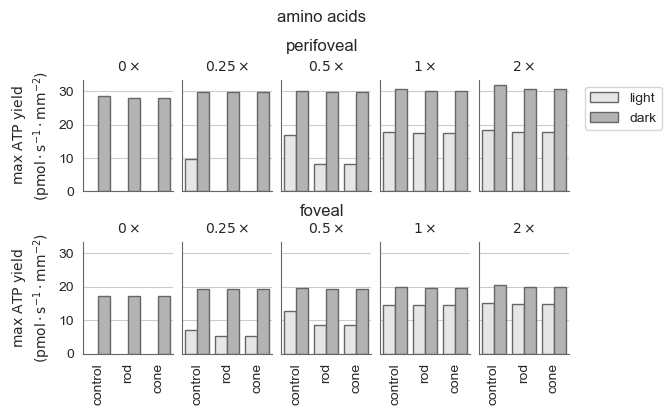

In [15]:
# create a barplot combined models
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)
sns.set_style("whitegrid")

# only combined and lukowskimodels
df_fig = df[df['single/combined'].isin(['combined'])]
df_fig = df_fig[df_fig['expression data'].isin(['Lukowski', 'control'])]

cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
df_fig['type'] = pd.Categorical(df_fig['type'], categories = cell_order, ordered = True)

g = sns.catplot(data=df_fig, x='type', \
            y='objective value',\
            hue='light/dark',\
            kind='bar', \
            col='aa_level',\
            row = 'foveal/perifoveal',\
            errorbar='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.gcf().set_size_inches(5,3)
set_axes()

plt.suptitle('amino acids', y = 1.2)
plt.gcf().text(0.5, 1.08, 'perifoveal', ha='center', va='center', fontsize = 12) # create text above first row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row

# titles = ['0 ×', '0.25 ×', '0.5 ×','1 ×','2 ×',\
#           '0 ×', '0.25 ×', '0.5 ×','1 ×','2 ×']

titles = [r'$\mathrm{0 \times}$', r'$\mathrm{0.25 \times}$', r'$\mathrm{0.5 \times}$', 
          r'$\mathrm{1 \times}$', r'$\mathrm{2 \times}$', r'$\mathrm{0 \times}$', 
          r'$\mathrm{0.25 \times}$', r'$\mathrm{0.5 \times}$', r'$\mathrm{1 \times}$', 
          r'$\mathrm{2 \times}$']

for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title, fontsize=10)

plt.gcf().axes[1].set_xticklabels(['control','rod','cone'])
plt.subplots_adjust(wspace = 0.1) # increase space between plots
plt.subplots_adjust(hspace = 0.45) # increase space between rows
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(5.5, 1.0))
plt.gcf().set_dpi(100)

# create folder to save figure
results_folder = create_folder('results', 'paper','figures')
plt.savefig(results_folder +  '/ATP_FBA_levels_aas_foveal_perifoveal.png', dpi=600, bbox_inches='tight')
df_fig.to_excel(results_folder + '/ATP_FBA_levels_aas_foveal_perifoveal.xlsx', index = False)


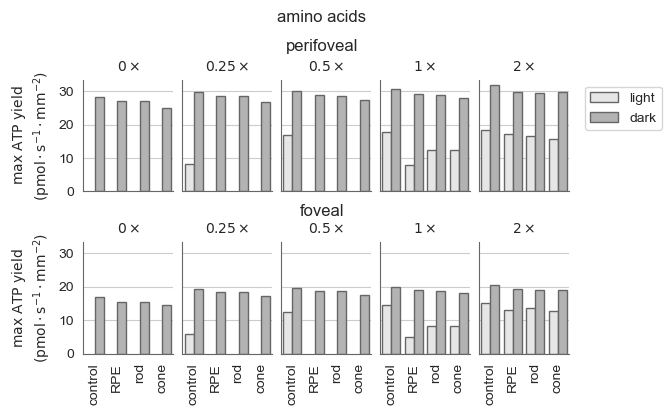

In [16]:
# create a barplot single models

# only single and lukowskimodels
df_fig = df[df['single/combined'].isin(['single'])]
df_fig = df_fig[df_fig['expression data'].isin(['Lukowski', 'control'])]

cell_order = ['control','RPE','PR rod','PR cone']
df_fig['type'] = pd.Categorical(df_fig['type'], categories = cell_order, ordered = True)

g = sns.catplot(data=df_fig, x='type', \
            y='objective value',\
            hue='light/dark',\
            kind='bar', \
            col='aa_level',\
            row = 'foveal/perifoveal',\
            errorbar='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.gcf().set_size_inches(5,3)
set_axes()

plt.suptitle('amino acids', y = 1.2)
plt.gcf().text(0.5, 1.08, 'perifoveal', ha='center', va='center', fontsize = 12) # create text above first row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row

# titles = ['0 x', '0.25 x', '0.5 x','1 x','2 x',\
#           '0 x', '0.25 x', '0.5 x','1 x','2 x']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title, fontsize=10)

plt.gcf().axes[1].set_xticklabels(['control','RPE','rod','cone'])
plt.subplots_adjust(wspace = 0.1) # increase space between plots
plt.subplots_adjust(hspace = 0.45) # increase space between rows
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(5.5, 1.0))
plt.gcf().set_dpi(100)

# create folder to save figure
results_folder = create_folder('results', 'paper','figures')
plt.savefig(results_folder +  '/ATP_FBA_levels_aas_foveal_perifoveal_single.png', dpi=600, bbox_inches='tight')

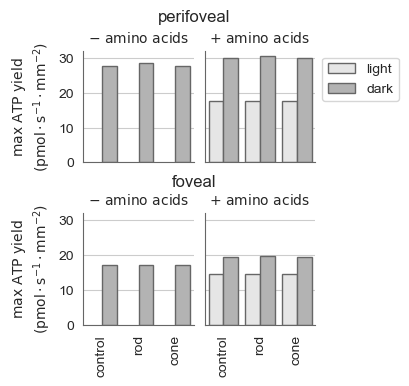

In [17]:
# make similar figure onl with 0.0 and 1.0 aa levels
df_fig = df[df['single/combined'].isin(['combined'])]
df_fig = df_fig[df_fig['expression data'].isin(['Lukowski', 'control'])]
df_fig = df_fig[df_fig['aa_level'].isin([1.00, 0.00])]

g = sns.catplot(data=df_fig, x='type', \
            y='objective value',\
            hue='light/dark',\
            kind='bar', \
            col='aa_level',\
            row = 'foveal/perifoveal',\
            errorbar='sd',\
            palette=my_palette, legend=False)

# titles = ['- amino acids', '+ amino acids',\
#           '- amino acids', '+ amino acids']

titles = [
    r'$\mathrm{-\ amino\ acids}$',
    r'$\mathrm{+\ amino\ acids}$',
    r'$\mathrm{-\ amino\ acids}$',
    r'$\mathrm{+\ amino\ acids}$'
    ]   

for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.legend().remove()

set_axes()

cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
plt.gcf().axes[0].set_xticklabels(cell_order)
plt.gcf().set_size_inches(2.5,3)
plt.gcf().text(0.5, 1.08, 'perifoveal', ha='center', va='center', fontsize = 12) # create text above first row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row
plt.gcf().axes[1].set_xticklabels(['control','rod','cone'])
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(2.1, 1.0))
plt.gcf().set_dpi(100)

plt.subplots_adjust(wspace = 0.1) # increase space between plots
plt.subplots_adjust(hspace = 0.45) # increase space between rows

# create folder to save figure
results_folder = create_folder('results', 'paper','figures')
plt.savefig(results_folder +  '/ATP_FBA_foveal_perifoveal.png', dpi=600, bbox_inches='tight')


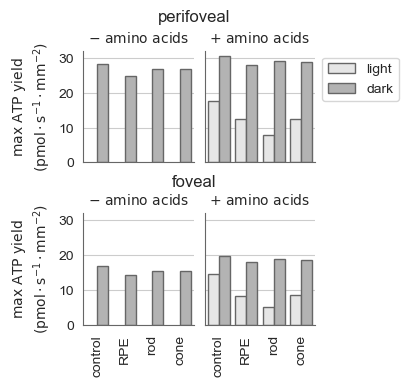

In [18]:
# single models
df_fig = df[df['single/combined'].isin(['single'])]
df_fig = df_fig[df_fig['expression data'].isin(['Lukowski', 'control'])]
df_fig = df_fig[df_fig['aa_level'].isin([1.00, 0.00])]
cell_order = ['control','RPE','PR rod','PR cone']   

g = sns.catplot(data=df_fig, x='type', \
            y='objective value',\
            hue='light/dark',\
            kind='bar', \
            col='aa_level',\
            row = 'foveal/perifoveal',\
            errorbar='sd',\
            palette=my_palette, legend=False)

set_axes()

titles = [
    r'$\mathrm{-\ amino\ acids}$',
    r'$\mathrm{+\ amino\ acids}$',
    r'$\mathrm{-\ amino\ acids}$',
    r'$\mathrm{+\ amino\ acids}$'
    ]  
 
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.legend().remove()

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.gcf().set_size_inches(2.5,3)
plt.gcf().text(0.5, 1.08, 'perifoveal', ha='center', va='center', fontsize = 12) # create text above first row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row
plt.gcf().axes[1].set_xticklabels(['control','RPE','rod','cone'])
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(2.1, 1.0))
plt.gcf().set_dpi(100)

plt.subplots_adjust(wspace = 0.1) # increase space between plots
plt.subplots_adjust(hspace = 0.45) # increase space between rows


# create folder to save figure
results_folder = create_folder('results', 'paper','figures')
plt.savefig(results_folder +  '/ATP_FBA_foveal_perifoveal_single.png', dpi=600, bbox_inches='tight')

Investigate effect of lipids with and without glucose

    MAR09089		phospholipids extracellular pool
    MAR13037		fatty acid-VLDL pool
    MAR13039		fatty acid-uptake pool
    MAR09209		fatty acid pool


In [19]:
model_list[0].reactions.get_by_id('MAR09089')

Reaction identifier,MAR09089
Name,
Memory address,0x20351455f00
Stoichiometry,MAM02740e --> phospholipids extracellular pool -->
GPR,
Lower bound,0
Upper bound,1000


In [20]:
model_list[0].metabolites.get_by_id('MAM01819e')

Metabolite identifier,MAM01819e
Name,fatty acid-uptake pool
Memory address,0x2034b0e18d0
Formula,CHO2R
Compartment,e
In 3 reaction(s),"MAR13039, MAR00012, MAR00011"


In [21]:
model_list[0].metabolites.get_by_id('MAM01820e')

Metabolite identifier,MAM01820e
Name,fatty acid-VLDL pool
Memory address,0x2034b0e1900
Formula,CHO2R
Compartment,e
In 5 reaction(s),"MAR13037, MAR00011, MAR00007, MAR10051, MAR00008"


In [22]:
model_list[0].metabolites.get_by_id('MAM10005e')

Metabolite identifier,MAM10005e
Name,fatty acid pool
Memory address,0x2034b9081c0
Formula,CO2R
Compartment,e
In 2 reaction(s),"MAR09209, MAR08720"


In [23]:
model_list[0].metabolites.get_by_id('MAM02740e')

Metabolite identifier,MAM02740e
Name,phospholipids extracellular pool
Memory address,0x2034b3c4490
Formula,C5H5O8PR3
Compartment,e
In 2 reaction(s),"MAR09089, MAR00477"


In [24]:
# import the function to create permutation dictionaries
from src.analysis import fba_analysis, create_permutation_dicts

lipids_exchange_bounds = {'MAR09089':(-1,1000),\
  'MAR13037':(-1,1000),\
  'MAR13039':(-1,1000),\
  'MAR09209':(-1,1000)}

# list of exchange bounds
lipids_exchange_bounds_list = [{'MAR09089':(-1,1000)},
    {'MAR13037':(-.1,1000)},
    {'MAR13039':(-.1,1000)},
    {'MAR09209':(-.1,1000)}]

close_lipids_exchange_bounds = {'MAR09089':(0,1000),\
  'MAR13037':(0,1000),\
  'MAR13039':(0,1000),\
  'MAR09209':(0,1000)}

In [25]:
# HUMAN1 ATP yield with no lipids
m = model_list[0]
set_bounds(m, ex_bounds_dark_perifoveal)
set_bounds(m, close_lipids_exchange_bounds)
fba = m.optimize()
fba.objective_value
print('ATP yield with no lipids: ' + str(fba.objective_value))

ATP yield with no lipids: 28.299999999999983


In [26]:
# HUMAN1 with lipids
set_bounds(m, ex_bounds_dark_perifoveal)
set_bounds(m, lipids_exchange_bounds)
fba = m.optimize()
print('ATP yield with lipids: ' + str(fba.objective_value))

ATP yield with lipids: 29.466683333333336


In [27]:
# for HUMAN1 model (model_list[0])  ex_bounds_dark_perifoveal
dict_fba = {}
for b in lipids_exchange_bounds_list:
    set_bounds(m, ex_bounds_dark_perifoveal)
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
    
df_fba = pd.DataFrame(dict_fba, index = [0])
print('ATP yield with different lipids, glucose (4.81), and limited oxygen (4.04): ')
df_fba

ATP yield with different lipids, glucose (4.81), and limited oxygen (4.04): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,28.3,28.3,29.466668,28.3


In [28]:
# for HUMAN1 model (model_list[0])  ex_bounds_dark_perifoveal
dict_fba = {}
for b in lipids_exchange_bounds_list:
    set_bounds(m, ex_bounds_dark_perifoveal)
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
    
df_fba = pd.DataFrame(dict_fba, index = [0])
print('ATP yield with different lipids, glucose (4.81), and limited oxygen (4.04): ')
df_fba

ATP yield with different lipids, glucose (4.81), and limited oxygen (4.04): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,28.3,28.3,29.466668,28.3


MAR13039:

fatty acid-uptake pool --> 

MAR00012:

fatty acid-uptake pool --> 


0.0001 (10Z)-heptadecenoic acid + 0.0001 (11Z,14Z)-eicosadienoic acid + 0.0001 (11Z,14Z,17Z)-eicosatrienoic acid + 0.0001 (13Z)-eicosenoic acid + 0.0001 (13Z)-octadecenoic acid + 0.0001 (13Z,16Z)-docosadienoic acid + 0.0001 (4Z,7Z,10Z,13Z,16Z)-DPA + 0.0001 (6Z,9Z)-octadecadienoic acid + 0.0001 (6Z,9Z,12Z,15Z,18Z)-TPA + 0.0001 (6Z,9Z,12Z,15Z,18Z,21Z)-THA + 0.0001 (7Z)-octadecenoic acid + 0.0001 (7Z)-tetradecenoic acid + 0.0001 (9E)-tetradecenoic acid + 0.0001 (9Z,12Z,15Z,18Z)-TTA + 0.0001 (9Z,12Z,15Z,18Z,21Z)-TPA + 0.0001 10,13,16,19-docosatetraenoic acid + 0.0001 10,13,16-docosatriynoic acid + 0.0001 12,15,18,21-tetracosatetraenoic acid + 0.0001 13,16,19-docosatrienoic acid + 0.0001 7-palmitoleic acid + 0.0001 8,11-eicosadienoic acid + 0.0001 9-eicosenoic acid + 0.0001 9-heptadecylenic acid + 0.0001 adrenic acid + 0.0082 arachidonate + 0.0001 behenic acid + 0.0001 cerotic acid + 0.0001 cis-cetoleic acid + 0.0001 cis-erucic acid + 0.0001 cis-gondoic acid + 0.0001 cis-vaccenic acid + 0.0041 DHA + 0.002 dihomo-gamma-linolenate + 0.0001 DPA + 0.0001 eicosanoate + 0.0001 elaidate + 0.001 EPA + 0.0001 gamma-linolenate + 0.0001 henicosanoic acid + 0.0001 lauric acid + 0.0001 lignocerate + 0.1535 linoleate + 0.0092 linolenate + 0.0001 margaric acid + 0.0001 mead acid + 0.0338 myristic acid + 0.0001 nervonic acid + 0.0001 nonadecylic acid + 0.3837 oleate + 0.0001 omega-3-arachidonic acid + 0.3015 palmitate + 0.0522 palmitolate + 0.0001 pentadecylic acid + 0.0001 physeteric acid + 0.046 stearate + 0.0001 stearidonic acid + 0.0001 tricosanoic acid + 0.0001 tridecylic acid + 0.0001 ximenic acid


In [29]:
# for HUMAN1 model (model_list[0])  ex_bounds_dark_perifoveal
dict_fba = {}
for b in lipids_exchange_bounds_list:
    # open oxygen exchange
    set_bounds(m, {'MAR09048': (-4.04, -4.04)})
    # close glucose exchange
    set_bounds(m, {'MAR09034':(0,0)})
    # open lactate eflux
    set_bounds(m, {'MAR09135': (0, 1000)})
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
df_fba = pd.DataFrame(dict_fba, index = [0])
print('ATP yield with different lipids, no glucose,  and limited oxygen (-4.04): ')
df_fba

ATP yield with different lipids, no glucose,  and limited oxygen (-4.04): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,-4.04,-4.04,10.055225,-4.04


In [30]:
# for HUMAN1 model (model_list[0])  ex_bounds_dark_perifoveal
dict_fba = {}
for b in lipids_exchange_bounds_list:
    # open oxygen exchange
    set_bounds(m, {'MAR09048': (-1000, 1000)})
    # close glucose exchange
    set_bounds(m, {'MAR09034':(0,0)})
    # open lactate eflux
    set_bounds(m, {'MAR09135': (0, 1000)})
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
df_fba = pd.DataFrame(dict_fba, index = [0])
print('ATP yield with different lipids, no glucose, and unlimited oxygen (1000): ')
df_fba

ATP yield with different lipids, no glucose, and unlimited oxygen (1000): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,0.0,0.0,11.652015,0.0


In [31]:
# for HUMAN1 model (model_list[0])  ex_bounds_dark_perifoveal
dict_fba = {}
for b in lipids_exchange_bounds_list:
    # open oxygen exchange
    set_bounds(m, {'MAR09048': (-1000, 1000)})
    # close glucose exchange
    set_bounds(m, {'MAR09034':(-4.81,-4.81)})
    # open lactate eflux
    set_bounds(m, {'MAR09135': (0, 1000)})
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
df_fba = pd.DataFrame(dict_fba, index = [0])
print('ATP yield with different lipids, glucose, and unlimited oxygen (1000): ')
df_fba

ATP yield with different lipids, glucose, and unlimited oxygen (1000): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,151.515,151.515,163.167015,151.515


In [32]:
# for HUMAN1 model (model_list[0])  LIGHT FOVEAL
dict_fba = {}
for b in lipids_exchange_bounds_list:
    # open oxygen exchange
    set_bounds(m, {'MAR09048': (-2.34, 1000)})
    # close glucose exchange
    set_bounds(m, {'MAR09034':(-1.51,1000)})
    # open lactate eflux
    set_bounds(m, {'MAR09135': (3.11, 1000)})
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
df_fba = pd.DataFrame(dict_fba, index = [0])
print('LIGHT FOVEAL: ATP yield with different lipids, glucose, and unlimited oxygen (1000): ')
df_fba

LIGHT FOVEAL: ATP yield with different lipids, glucose, and unlimited oxygen (1000): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,None,None,13.209635,None


In [33]:
# for HUMAN1 model (model_list[0])  LIGHT PERIFOVEAL
dict_fba = {}
for b in lipids_exchange_bounds_list:
    # open oxygen exchange
    set_bounds(m, {'MAR09048': (-2.76, 1000)})
    # close glucose exchange
    set_bounds(m, {'MAR09034':(-2.04,1000)})
    # open lactate eflux
    set_bounds(m, {'MAR09135': (4.2, 1000)})
    set_bounds(m, close_lipids_exchange_bounds)
    set_bounds(m, b) # open lipids exchange per lipid pool
    fba = m.optimize()
    dict_fba[str(b)] = fba.objective_value
df_fba = pd.DataFrame(dict_fba, index = [0])
print('LIGHT PERIFOVEAL: ATP yield with different lipids, glucose, and unlimited oxygen (1000): ')
df_fba

LIGHT PERIFOVEAL: ATP yield with different lipids, glucose, and unlimited oxygen (1000): 


,"{'MAR09089': (-1, 1000)}","{'MAR13037': (-0.1, 1000)}","{'MAR13039': (-0.1, 1000)}","{'MAR09209': (-0.1, 1000)}"
0,None,None,13.782135,None


In [34]:
import numpy as np
import pandas as pd

def lipid_sweep(glucose_bounds, oxygen_bounds, lactate_bounds, set_bounds_function, model, step=0.2):
    """
    Runs Flux Balance Analysis (FBA) for different combinations of metabolite exchange bounds.

    Parameters:
    - glucose_bounds: List of tuples defining the bounds for glucose exchange.
    - oxygen_bounds: List of tuples defining the bounds for oxygen exchange.
    - lactate_bounds: List of tuples defining the bounds for lactate exchange.
    - set_bounds_function: Function to set the bounds in the model.
    - model: The metabolic model to be optimized.
    - step: The step size for iterating over MAR13039 (lipids) bounds. Default is 0.2.

    Returns:
    - A pandas DataFrame containing the FBA results.
    """

    # Initialize a dictionary to hold FBA results
    df_fba_results = {'MAR13039': [], 'Glucose': [], 'Oxygen': [], 'Lactate': [], 'ATP_Yield': []}

    # Loop through each combination of glucose, oxygen, lactate, and MAR13039 (lipids, i)
    for glucose in glucose_bounds:
        for oxygen in oxygen_bounds:
            for lactate in lactate_bounds:
                for i in np.arange(0, 10.2, step):
                    # close all lipid exchange bounds
                    set_bounds_function(model, {'MAR09089': (0, 0), 'MAR13037': (0, 0), 'MAR13039': (0, 0), 'MAR09209': (0, 0)})
                    
                    # Set bounds for each metabolite exchange
                    set_bounds_function(model, {'MAR09034': glucose, 'MAR09048': oxygen, 'MAR09135': lactate, 'MAR13039': (-i, 1000)})
                    
                    # Optimize model
                    fba = model.optimize()
                    
                    # Store results in dict
                    df_fba_results['MAR13039'].append(-i)
                    df_fba_results['Glucose'].append(glucose[0])  # Only storing the lower bound for simplicity
                    df_fba_results['Oxygen'].append(oxygen[0])  # Only storing the lower bound for simplicity
                    df_fba_results['Lactate'].append(lactate[0])  # Only storing the lower bound for simplicity
                    df_fba_results['ATP_Yield'].append(fba.objective_value)

    # Convert the dictionary to a DataFrame
    df_fba_results = pd.DataFrame(df_fba_results)

    return df_fba_results


In [35]:
# # LIGHT PERIFOVEAL: glucose, oxygen, and lactate bounds
glucose_bounds = [(0, 0), (-2.04, 1000)]  # MAR09034
oxygen_bounds = [(0, 0), (-2.76, 1000), (-1000, 1000)]  # MAR09048
lactate_bounds = [(4.2, 1000), (0, 1000)]  # MAR09135
df_lipids_light = lipid_sweep(glucose_bounds, oxygen_bounds, lactate_bounds, set_bounds, model_list[0])

# DARK PERIFOVEAL: glucose, oxygen, and lactate bounds
glucose_bounds = [(0, 0), (-4.81, 1000)]  # MAR09034
oxygen_bounds = [(0, 0), (-4.04, 1000), (-1000, 1000)]  # MAR09048
lactate_bounds = [(8.34, 1000), (0, 1000)]  # MAR09135
df_lipids_dark = lipid_sweep(glucose_bounds, oxygen_bounds, lactate_bounds, set_bounds, model_list[0])

# light foveal bounds
glucose_bounds = [(0, 0), (-1.51, 1000)]  # MAR09034
oxygen_bounds = [(0, 0), (-2.34, 1000), (-1000, 1000)]  # MAR09048
lactate_bounds = [(3.11, 1000), (0, 1000)]  # MAR09135
df_lipids_light_foveal = lipid_sweep(glucose_bounds, oxygen_bounds, lactate_bounds, set_bounds, model_list[0])

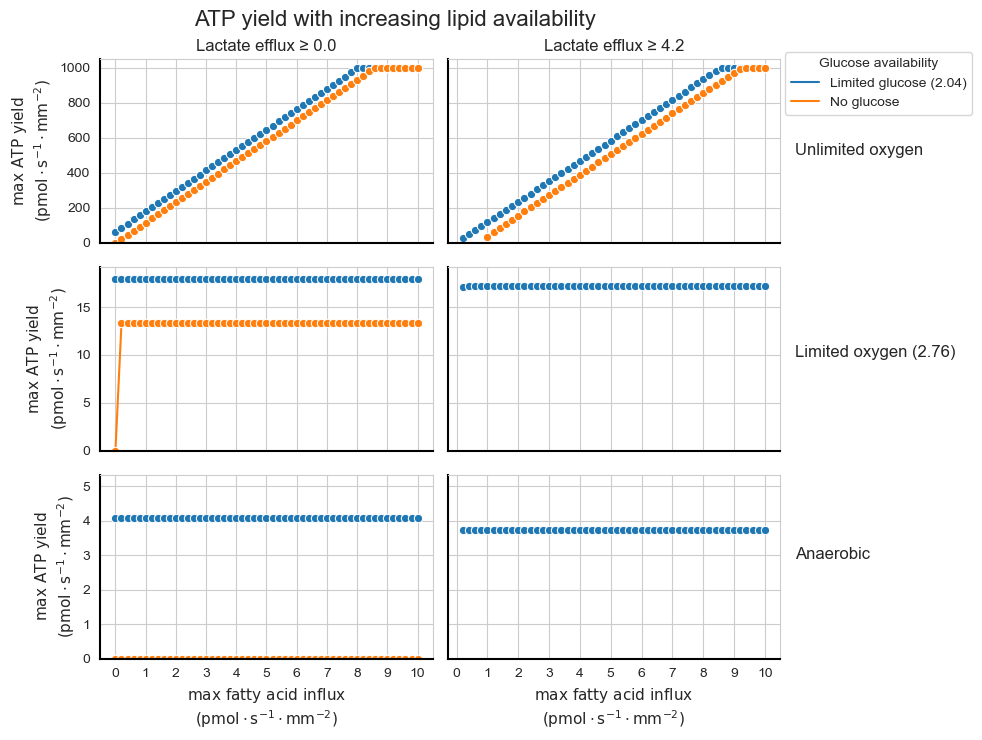

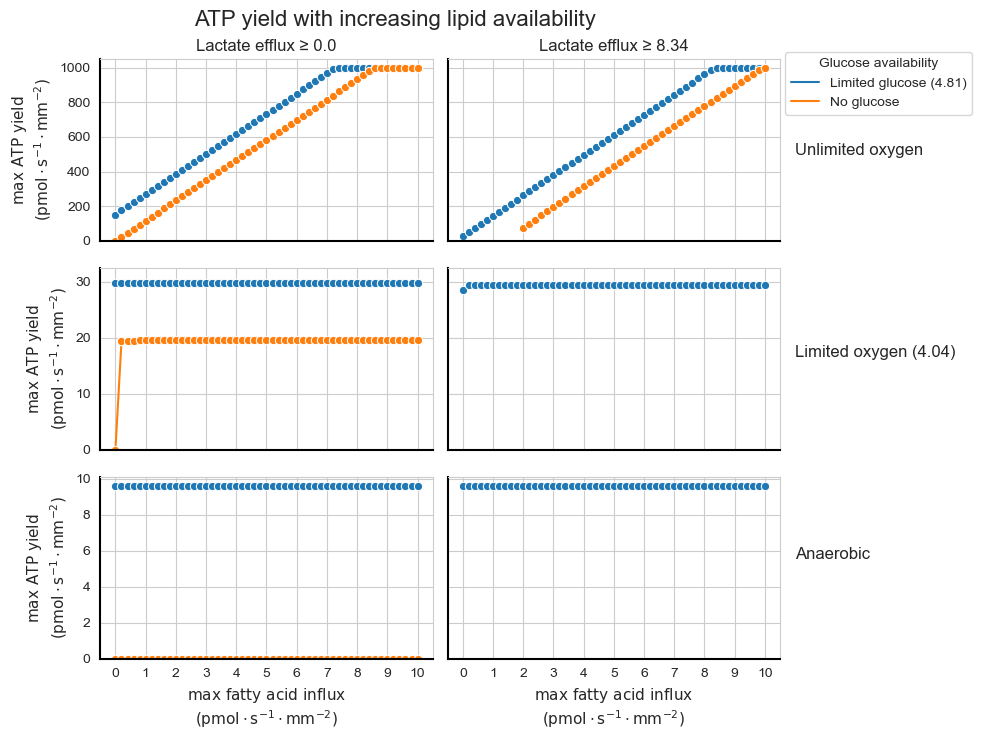

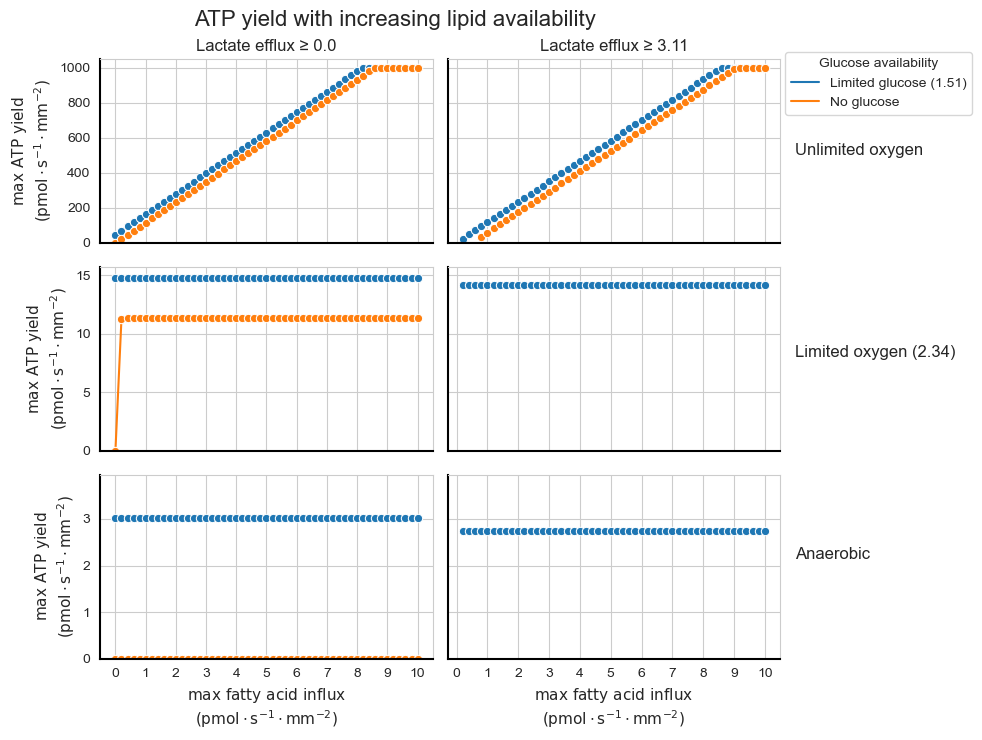

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_fba_results(df_fba):
    """
    Plots ATP yield for different levels of lactate and oxygen with varying lipid (MAR13039) availability.

    Parameters:
    - df_fba: DataFrame containing FBA results with columns 'Lactate', 'Oxygen', 'MAR13039', 'ATP_Yield', and 'Glucose'.
    """

    # use absolute values for MAR13039
    df_fba['MAR13039'] = df_fba['MAR13039'].abs()
    
    # Sort the Lactate and Oxygen levels for logical ordering in the plot
    lactate_levels = sorted(df_fba['Lactate'].unique())
    oxygen_levels = sorted(df_fba['Oxygen'].unique())

    # Set up the matplotlib figure with subplots
    fig, axes = plt.subplots(len(oxygen_levels), len(lactate_levels), figsize=(20, 6 * len(oxygen_levels)), sharex='col', sharey='row')

    # Ensure axes is a 2D array for easy indexing
    if len(oxygen_levels) == 1:
        axes = np.array([axes]).reshape(-1, len(lactate_levels))
    if len(lactate_levels) == 1:
        axes = np.array([axes]).reshape(len(oxygen_levels), -1)

    # Enhance overall aesthetics
    sns.set_style("whitegrid")
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle('ATP yield with increasing lipid availability', fontsize=16, y=1.05)
    # FIG SIZE
    fig.set_size_inches(7,5)

    # Plotting
    for i, oxygen_level in enumerate(oxygen_levels):
        for j, lactate_level in enumerate(lactate_levels):
            ax = axes[i, j]
            df_filtered = df_fba[(df_fba['Lactate'] == lactate_level) & (df_fba['Oxygen'] == oxygen_level)]
            sns.lineplot(data=df_filtered, x='MAR13039', y='ATP_Yield', hue='Glucose', ax=ax, marker='o', linestyle='-', palette=['#1f77b4', '#ff7f0e'], legend=True)
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='major', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.set_xticks(np.arange(min(df_fba['MAR13039']), max(df_fba['MAR13039']) + 1, 1.0))

    # Adjust legends, labels, and layout
    for ax in axes.flatten():
        ax.get_legend().remove()
        # ax.set_xlabel('Upper limit fatty acid-uptake (pmol·s$^-1$·mm$^-2$)', fontsize=12)
        # ax.set_ylabel('Max ATP yield\n(pmol·s$^-1$·mm$^-2$)', fontsize=12)
        ax.set_xlabel(r'$\mathrm{max\ fatty\ acid\ influx}$' + '\n' + r'$(\mathrm{pmol \cdot s^{-1} \cdot mm^{-2}})$', fontsize=11)
        ax.set_ylabel(r'$\mathrm{max\ ATP\ yield}$' + '\n' + r'$(\mathrm{pmol \cdot s^{-1} \cdot mm^{-2}})$', fontsize=11)
        ax.set_ylim(bottom=0)

    # Customizing the figure
    fig.set_size_inches(8, 7)
    plt.tick_params(axis='x', which='major', direction='out')
    handles, labels = ax.get_legend_handles_labels()

    # get glucose level that is non zero
    glucose_level = df_fba['Glucose'].unique()[1]
    # get oxygen level that is non zero and non -1000
    oxygen_level = df_fba['Oxygen'].unique()[1]

    fig.legend(handles, ['Limited glucose (' + str(-glucose_level) + ')', 'No glucose'], loc='upper right', title='Glucose availability', bbox_to_anchor=(1.23, 1), fontsize=10)
    fig.tight_layout()
    fig.subplots_adjust(top=.98)

    # Add titles and enhance spines
    for i, lactate_level in enumerate(lactate_levels):
        axes[0, i].set_title(f'Lactate efflux ≥ {lactate_level}', fontsize=12)

    dg = 'black'  # Assuming 'dg' is the color for the dark grid lines
    for ax in axes.flatten():
        ax.spines['bottom'].set_color(dg)
        ax.spines['left'].set_color(dg)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
    
    # Adjust for the custom oxygen condition labels
    oxygen_labels = ['Unlimited oxygen', 'Limited oxygen (' + str(-oxygen_level) + ')', 'Anaerobic']  # Example labels, adjust as needed
    for i, oxygen_level in enumerate(oxygen_levels):
        label = oxygen_labels[i] if i < len(oxygen_labels) else f'Oxygen level {oxygen_level}'
        fig.text(1.0, 0.85 - i * 0.289, label, ha='left', va='center', fontsize=12)
    plt.show()


# Plot the results for the light and dark conditions
plot_fba_results(df_lipids_light)
plot_fba_results(df_lipids_dark)
plot_fba_results(df_lipids_light_foveal)

Sweep function

In [37]:
##############################################################
############## SWEEPS (Lactate, Glucose, Oxygen) #############
##############################################################

def sweep(sweep_ID, ex_bounds, ex_bounds_str, sweep_values, fix_sweep_bounds = True):
    
    df_all = dict()
    for b, b_str, s in zip(ex_bounds, ex_bounds_str, sweep_values):  
        s = my_range(s[0],s[1],s[2])
        df = dict()
        for br in [br_list[1], br_list[-1]]:
            df[br[glucose_ID]]  = analysis(model_list = model_list, b = b, br = br,\
                                            sweep_ID = sweep_ID, sweep_values = s, fix_sweep_bounds = fix_sweep_bounds)
        df_all[b_str] = pd.concat(df, axis = 0)

    return df_all


Functions for post analysis processing (preparing for figs)

In [38]:
def model_name2type(model_name):
    if 'singlePR' in model_name:
        if 'PRcone' in model_name:
            return 'single PR cone'
        elif 'PRrod' in model_name:
            return 'single PR rod'
    elif 'singleRPE' in model_name:
        if 'PRcone' in model_name:
            return 'single RPE 1'
        elif 'PRrod' in model_name:
            return 'single RPE 2'
    elif 'mod_RPE_PR' and 'single' not in model_name:
        if 'PRcone' in model_name:
            return 'combined RPE - PR cone'
        elif 'PRrod' in model_name:
            return 'combined RPE - PR rod'
        elif 'control' in model_name:
            return 'combined RPE - PR control'
    if 'Human-GEM' in model_name:
        return 'single control'
    else: 
        return model_name
    
def df4plot(df):
    sweep_ID = df.columns[0]
    df = df.reset_index()
    df = df.drop(columns=['level_1']) # remove level_1 column
    df = df.rename(columns={'level_0': 'aas'}) # rename level_0 to aas
    df = df.melt(id_vars=[sweep_ID, 'aas'], var_name='model', value_name='objective value') # melt to long format for figures
    df.insert(2, 'type', df['model'].apply(model_name2type)) # insert type column after aas column
    # make list with 'Lukowski', 'Liang' or '' depending on string match for model name in df
    df['dataset'] = df['model'].apply(lambda x: 'Lukowski' if 'Lukowski' in x else 'Liang' if 'Liang' in x else '')
    return df
    

Set parameters for subsequent sweep analyses

In [39]:
lactate_ID = 'MAR09135'
glucose_ID = 'MAR09034'
oxygen_ID = 'MAR09048'

ex_bounds = [ex_bounds_light_perifoveal, ex_bounds_dark_perifoveal,\
            ex_bounds_light_foveal, ex_bounds_dark_foveal]

single_ex_bounds = [convert_dict2single(b) for b in ex_bounds]
    
ex_bounds_str = ['light perifoveal', 'dark perifoveal',\
                'light foveal', 'dark foveal']

keys = ex_bounds_str

ex_bounds4textbox = dict(zip(ex_bounds_str, [convert_dict2single(b) for b in ex_bounds]))

# make dict with ex_bounds_str as keys and the dicts in single_ex_bounds as values
ex_bounds_dict = dict(zip(ex_bounds_str, single_ex_bounds))


Before starting sweeps, reset exchange bounds

In [40]:
# close influx for all models before starting the sweeps
close_influx(model_list)

Lactate sweep

In [ ]:
## uncomment and run to run new sweep (takes about two hours)
# lactate_sweep_values = [(2.5,6,0.1), (7,15,0.1), (0,4.5,0.1), (0,9,0.1)]
# lactate_df = sweep(lactate_ID, ex_bounds, ex_bounds_str, lactate_sweep_values)
# [lactate_df.update({key: df4plot(lactate_df[key])}) for key in lactate_df.keys()]

# pickle df
pickle_folder = Path().cwd() / 'results' / 'lactate' / 'pickles'

# creat pickle folder if it does not exist
# if not pickle_folder.exists():
#     pickle_folder.mkdir(parents=True)
# for k in keys:
#     pickle_file_name = 'lactate_' + k + '.pkl'
#     lactate_df[k].to_pickle(pickle_folder / pickle_file_name)

# load pickles
lactate_df = dict()
for k in keys:
    pickle_file_name = 'lactate_' + k + '.pkl'
    lactate_df[k] = pd.read_pickle(pickle_folder / pickle_file_name)

Glucose sweep

In [ ]:
# # uncomment and run to run new sweep (takes about three hours) 
# glucose_sweep_values = [(-8,0,.1), (-8,0,.1), (-8,0,.1), (-8,0,.1)]
# glucose_df = sweep(glucose_ID, ex_bounds, ex_bounds_str, glucose_sweep_values)
# [glucose_df.update({key: df4plot(glucose_df[key])}) for key in glucose_df.keys()]

# # pickle df
pickle_folder = Path().cwd() / 'results' / 'glucose' / 'pickles'

# for k in keys:
#     pickle_file_name = 'glucose_' + k + '.pkl'
#     glucose_df[k].to_pickle(pickle_folder / pickle_file_name)

# load pickles
glucose_df = dict()
for k in keys:
    pickle_file_name = 'glucose_' + k + '.pkl'
    glucose_df[k] = pd.read_pickle(pickle_folder / pickle_file_name)

Oxygen sweep

In [ ]:
# # uncomment and run to run new sweep (takes about three hours)

# oxygen_sweep_values = [(-6,0.5,.1), (-6,0.5,.1), (-6,0.5,.1), (-6,0.5,.1)]
# oxygen_df = sweep(oxygen_ID, ex_bounds, ex_bounds_str, oxygen_sweep_values)
# [oxygen_df.update({key: df4plot(oxygen_df[key])}) for key in oxygen_df.keys()]

# # pickle df
pickle_folder = Path().cwd() / 'results' / 'oxygen' / 'pickles'

# for k in keys:
#     pickle_file_name = 'oxygen_' + k + '.pkl'
#     oxygen_df[k].to_pickle(pickle_folder / pickle_file_name)

# load pickles
oxygen_df = dict()
for k in keys:
    pickle_file_name = 'oxygen_' + k + '.pkl'
    oxygen_df[k] = pd.read_pickle(pickle_folder / pickle_file_name)

Oxygen sweep (without fixing exchange bounds!)

In [ ]:
# uncomment and run to run new sweep (takes about two hours)
oxygen_sweep_values = [(-6,0.5,.1), (-6,0.5,.1), (-6,0.5,.1), (-6,0.5,.1)]
oxygen_df2 = sweep(oxygen_ID, ex_bounds, ex_bounds_str, oxygen_sweep_values, fix_sweep_bounds = False)
[oxygen_df2.update({key: df4plot(oxygen_df2[key])}) for key in oxygen_df2.keys()]

# # pickle df
pickle_folder = Path().cwd() / 'results' / 'oxygen' / 'pickles'
for k in keys:
    pickle_file_name = 'oxygen_efflux_allowed_' + k + '.pkl'
    oxygen_df2[k].to_pickle(pickle_folder / pickle_file_name)

# load pickles
pickle_folder = Path().cwd() / 'results' / 'oxygen' / 'pickles'
oxygen_df2 = dict()
for k in keys:
    pickle_file_name = 'oxygen_efflux_allowed_' + k + '.pkl'
    oxygen_df2[k] = pd.read_pickle(pickle_folder / pickle_file_name)
    

Functions to create figures

In [ ]:
#from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

def dg_axes():
    dg=(.4, .4, .4,.6) # dark gray
    for ax in plt.gcf().axes:
        ax.spines['bottom'].set_color(dg)
        ax.spines['left'].set_color(dg)
        #set spine linewidth to 1
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        for p in ax.patches:
            p.set_edgecolor(dg)
            p.set_linewidth(1)

def influx_efflux(met):
    if met == 'glucose':
        influx_efflux_text = 'influx'
    elif met == 'lactate':
        influx_efflux_text = 'efflux'
    elif met == 'oxygen':
        influx_efflux_text = 'influx'
    else:
        influx_efflux_text = 'exchange'
    return influx_efflux_text

def sweep_fig(df,k,single_combined='single',sweep_metabolite=''):

    markers=['o','s','^','D','P','X','*','+','v','<','>','H','d','p','x','8','1','2','3','4','h','|','_']

    ex_bounds = ex_bounds4textbox[k]

    if single_combined == 'single':
        df = df[(df['type'].str.contains('single')) &  ((df['dataset'] == 'Lukowski') | (df['dataset'] == ''))].copy() # only use Lukowski models 
        categories_order = ["control", "PR cone", "PR rod", "single RPE"]     
    elif single_combined == 'combined':
        df = df[(df['type'].str.contains('combined')) &  ((df['dataset'] == 'Lukowski') | (df['dataset'] == ''))].copy()
        categories_order = ["control", "PR cone", "PR rod"]

    unique_types = df['type'].unique()
    ordered_types = [s for category in categories_order for s in unique_types if category in s]
    df['type'] = pd.Categorical(df['type'], categories=ordered_types, ordered=True)
    df[df.columns[0]] = pd.to_numeric(df[df.columns[0]])

    # for glucose and oxygen multiply df[df.columns[0]]  by -1 so that x-axis is influx
    if sweep_metabolite == glucose_ID or sweep_metabolite == oxygen_ID:
        df[df.columns[0]] = df[df.columns[0]] * -1

    if 'light' in k:
        sns.set_style("whitegrid")
    elif 'dark' in k:
        sns.set_style("darkgrid")

    # Initialize the FacetGrid
    g = sns.FacetGrid(df, col="aas",\
                        hue="type",\
                        palette='colorblind', \
                        legend_out=False)

    g.fig.set_size_inches(6, 3)
    g.fig.subplots_adjust(wspace=200)

    # Ensure you have enough markers for the unique types
    if len(ordered_types) > len(markers):
        raise ValueError("Not enough markers for the number of types")
    type_to_marker = {utype: marker for utype, marker in zip(ordered_types, markers)}

    # # Modify the plotting code to use different markers for each type
    def scatterplot_with_markers(x, y, label, **kwargs):
        plt.scatter(x, y, marker=type_to_marker[label],edgecolors= "white", linewidth=.5, **kwargs)

    # # The map method is used to apply a function (func) to each subplot within the grid.
    g.map(scatterplot_with_markers, df.columns[0], "objective value")

    plt.ylim(0, 45)
    dg_axes()
    plt.suptitle(k)
    plt.subplots_adjust(top=0.78)

    # labels sublpots
    axes = g.axes.flatten()
    axes[0].set_title(r'$\mathrm{-\ amino\ acids}$', fontsize=11)
    axes[1].set_title(r'$\mathrm{+\ amino\ acids}$', fontsize=11)
    axes[0].set_ylabel(r'$\mathrm{max\ ATP\ yield}$' +\
                        '\n' + r'$(\mathrm{pmol \cdot s^{-1} \cdot mm^{-2}})$', \
                        fontsize=10)

    ###############################################################################################
    ############################## TEXTBOX WITH EXCHANGE BOUNDS ###################################
    ###############################################################################################

    metabolite_mapping = {
        '': '',
        lactate_ID: 'lactate',
        glucose_ID: 'glucose',
        oxygen_ID: 'oxygen'}

    # Get the corresponding string for sweep_metabolite
    sweep_metabolite_str = metabolite_mapping.get(sweep_metabolite, sweep_metabolite)

    # # Getting the exchange bounds for each metabolite and multiplying by -1 if necessary
    met1, met1_value = 'glucose',  "{:.2f}".format(ex_bounds[glucose_ID][0]*-1)
    met2, met2_value = 'oxygen',  "{:.2f}".format(ex_bounds[oxygen_ID][0]*-1)
    met3, met3_value = 'lactate',  "{:.2f}".format(ex_bounds[lactate_ID][0])
    
    # textbox with line0: exchange bounds (pmol/s/mm2); line1: met1 influx/efflux: met1_value; line2: met2 influx/efflux: met2_value,
    # write line1 in latex
    line1 = r'$\mathrm{exchange\ (pmol \cdot s^{-1} \cdot mm^{-2}})$'

    line2 = '    ' + met1 + ' ' + influx_efflux(met1) + ': ' + met1_value
    line3 = '    ' + met2 + ' ' + influx_efflux(met2) + ': ' + met2_value
    line4 = '    ' + met3 + ' ' + influx_efflux(met3) + ': ' + met3_value

    # function to make line2 and line3 and line4
    def make_line(met, met_value):
        line = '    ' + met + ' ' + influx_efflux(met) + ': ' + met_value
        if met == sweep_metabolite_str:
            line = line + ' (ref)'
        return line

    line2 = make_line(met1, met1_value)
    line3 = make_line(met2, met2_value)
    line4 = make_line(met3, met3_value)

    textstr =  line1 + '\n' + line2 + '\n' + line3 + '\n' + line4

    
    ###############################################################################################
    ###############################################################################################
    ###############################################################################################

    for ax in axes:
        # set xlabel totally in latex using sweep_metabolite_str text 
        ax.set_xlabel(r'$\mathrm{' + sweep_metabolite_str + '}$' + \
                      ' ' + r'$\mathrm{' + influx_efflux(sweep_metabolite_str) + '}$' + \
                      '\n' + r'$(\mathrm{pmol \cdot s^{-1} \cdot mm^{-2}})$', fontsize=10)

        ax.xaxis.set_major_locator(plt.MaxNLocator(7)) # set max 7 spaced xticks

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1.1, .3, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
    
    marker_size = 20  # Adjust this value as needed for your desired marker size
    for ax in g.axes.flatten():
        for point in ax.collections:
            point.set_sizes([marker_size])
        for line in ax.lines:
            line.set_linewidth(1)

    # Create and add the legende
    legend_handles = [mlines.Line2D([], [], color=sns.color_palette('colorblind')[i], \
                    marker=type_to_marker[utype], linestyle='None', markersize=6, label=utype) \
                    for i, utype in enumerate(ordered_types)]
  
    # legend (align to left)
    g.add_legend(handles=legend_handles, title='model type',\
                bbox_to_anchor=(2.25, 1),loc='upper left',\
                ncol=1, borderaxespad=0.1, fontsize=10)
    
    if single_combined == 'combined':
        if g._legend is not None:
            for text in g._legend.texts:
                # Remove 'combined ' from the label
                text.set_text(text.get_text().replace('combined ', ''))

    # save figure
    folder = create_folder('results', 'paper','sweep', sweep_metabolite_str, 'figures')
    # save exach figure as plotted
    plt.savefig(folder + '/' + sweep_metabolite_str + '_' + k + '_' + single_combined + '.jpg', bbox_inches='tight', dpi=400)

    # save df as excel
    folder = create_folder('results', 'paper','sweep', sweep_metabolite_str, 'excel')
    df.to_excel(folder + '/' + sweep_metabolite_str + '_' + k + '_' + single_combined + '.xlsx', index=False)

def make_figs(df,sweep_id, xlim):
    keys = ['light perifoveal', 'dark perifoveal', 'light foveal', 'dark foveal']
    for k, xlim in zip(keys, xlim):
        sweep_fig(df[k],k,single_combined='single',sweep_metabolite=sweep_id)
        plt.xlim(xlim)
        # save figure
        folder = create_folder('results', 'paper','sweep', sweep_id, 'figures_single')
        plt.savefig(folder + '/' + sweep_id + '_' + k + '_single.jpg', bbox_inches='tight', dpi=400)

        sweep_fig(df[k],k,single_combined='combined',sweep_metabolite=sweep_id)
        plt.xlim(xlim)
        # save figure
        folder = create_folder('results', 'paper','sweep', sweep_id, 'figures_combined')
        plt.savefig(folder + '/' + sweep_id + '_' + k + '_combined.jpg', bbox_inches='tight', dpi=400)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning

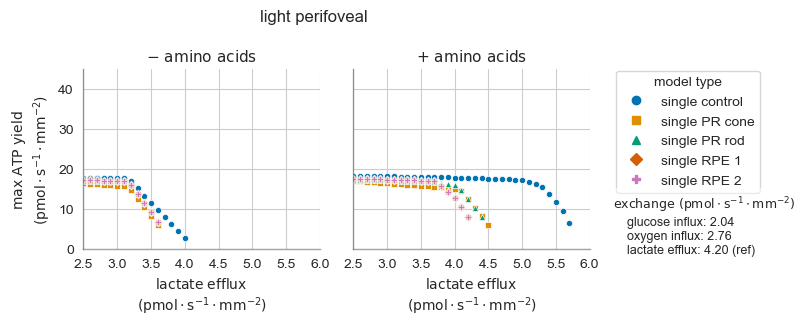

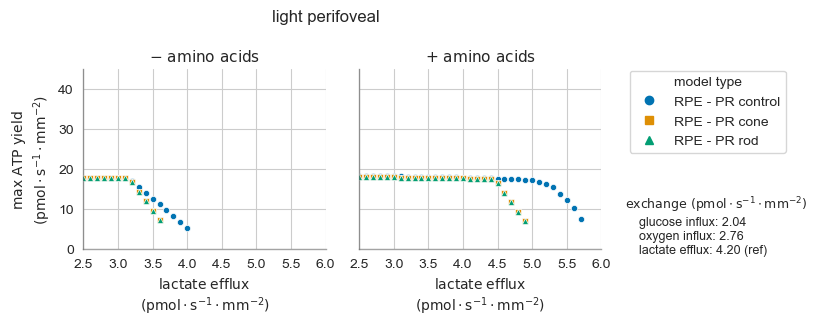

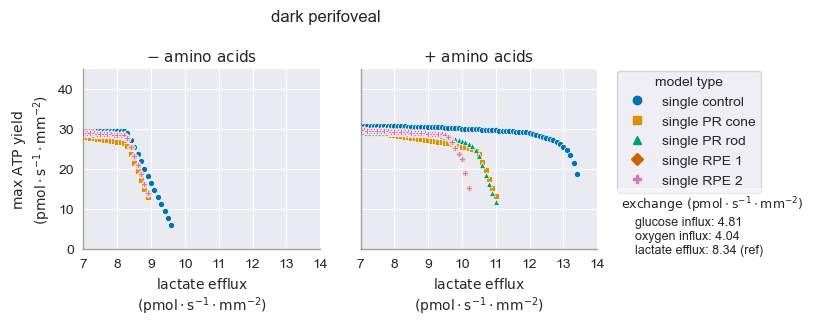

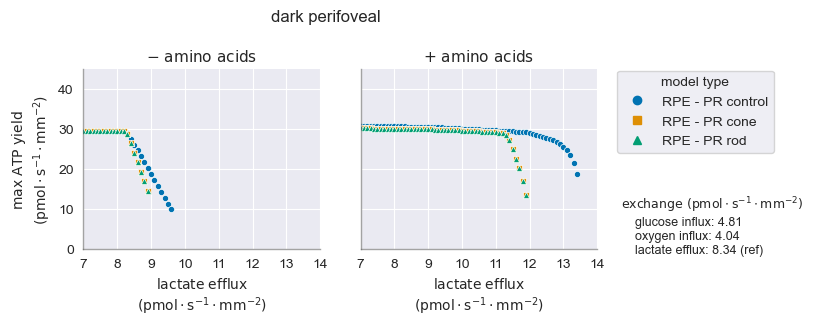

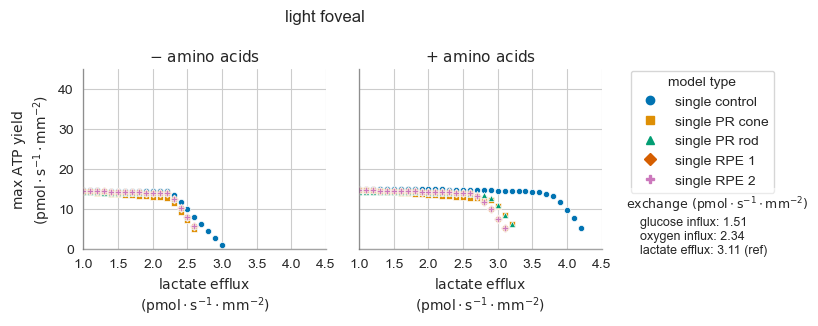

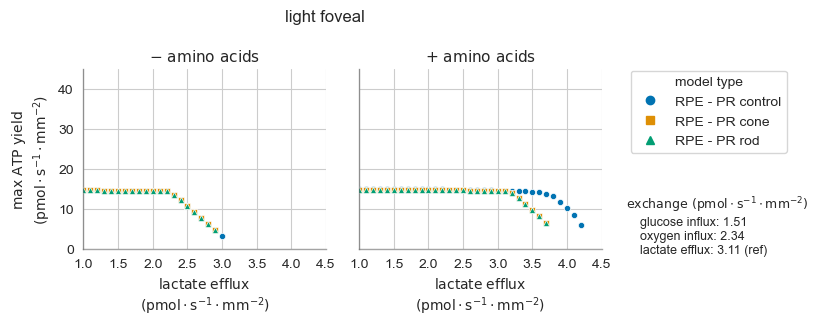

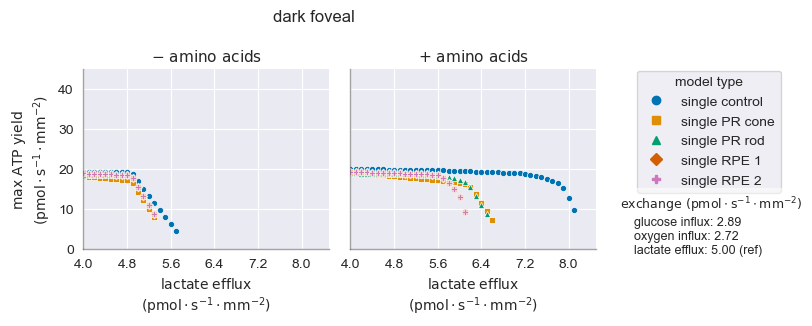

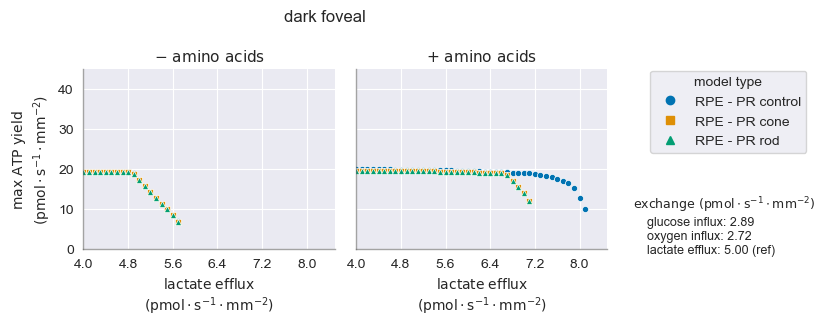

In [ ]:
make_figs(lactate_df,lactate_ID, [(2.5, 6), (7, 14), (1, 4.5),( 4, 8.5)])

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning

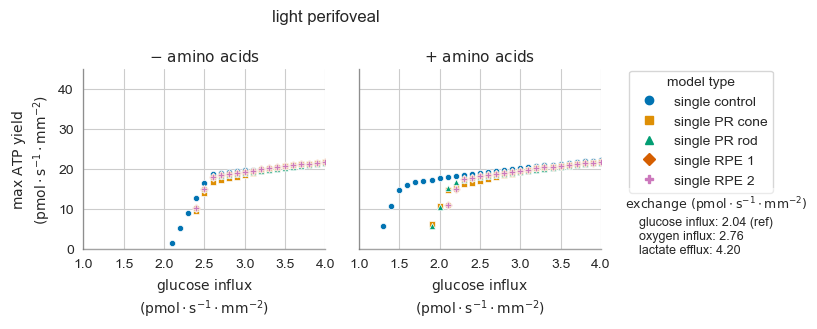

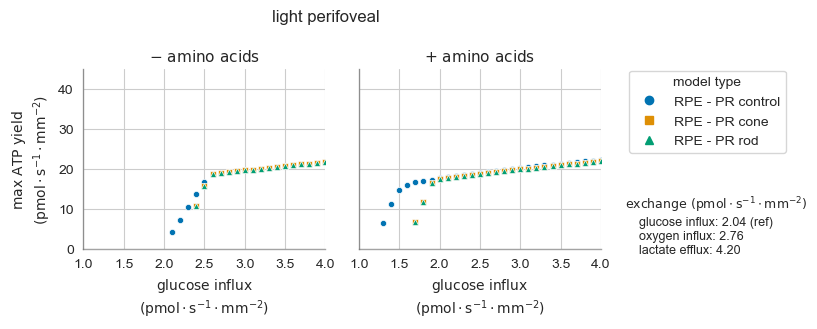

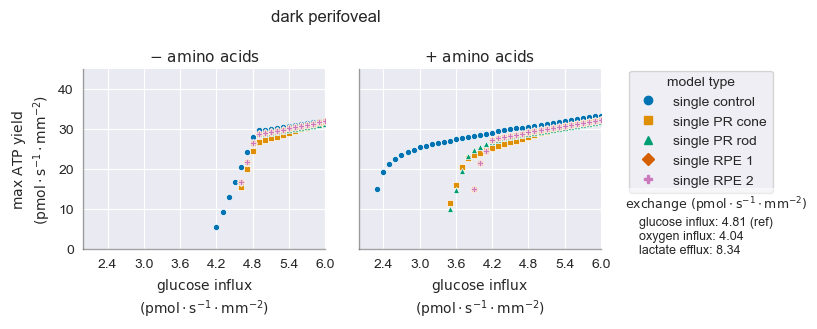

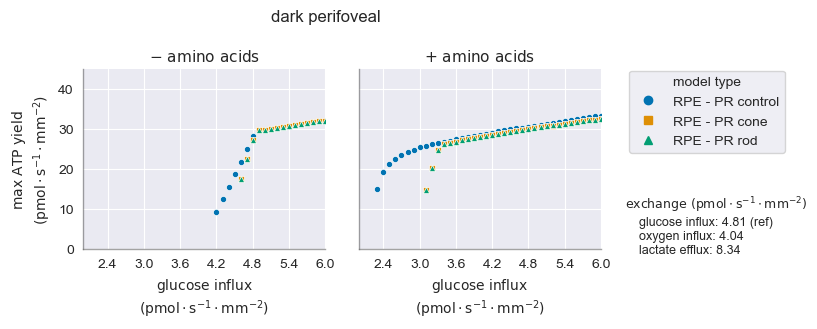

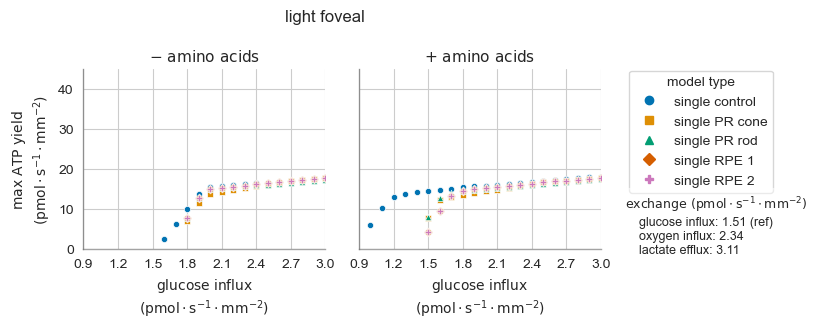

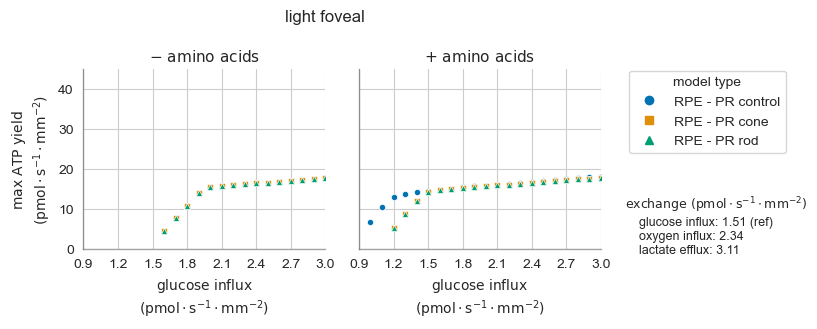

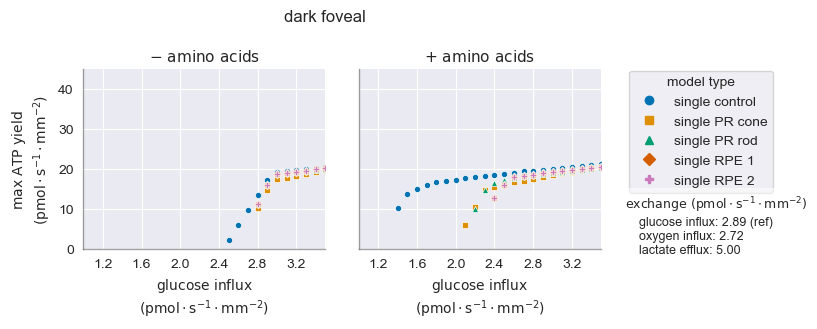

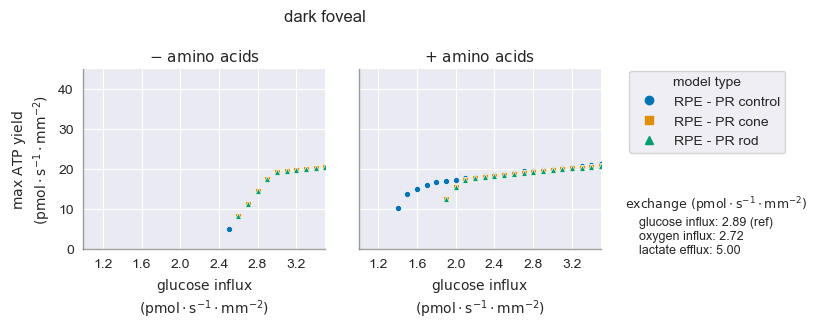

In [ ]:
# make glucose figures
make_figs(glucose_df,glucose_ID, [(1,4), (2,6), (0.9,3), (1,3.5)])

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning

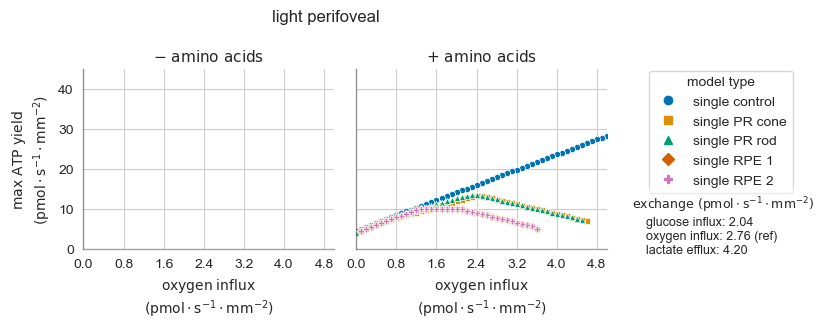

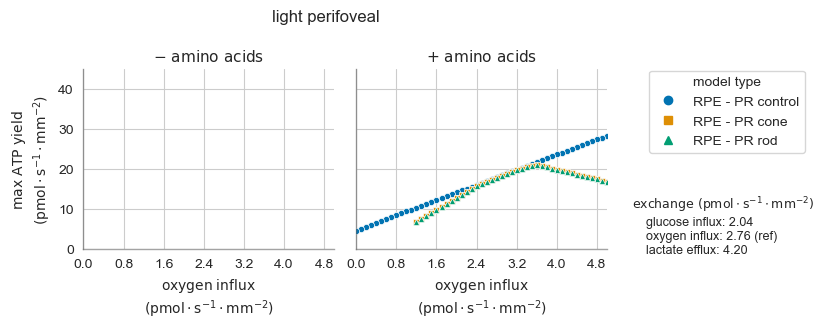

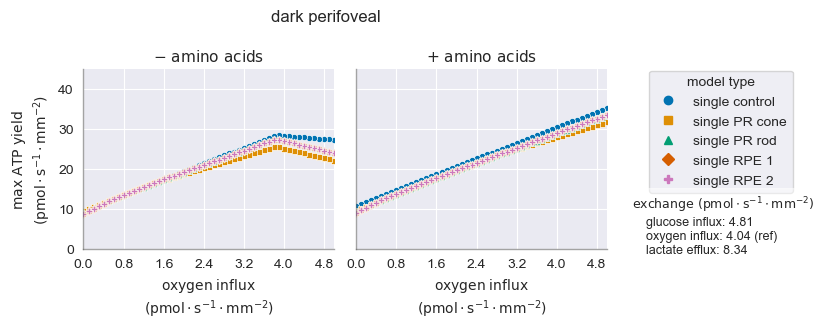

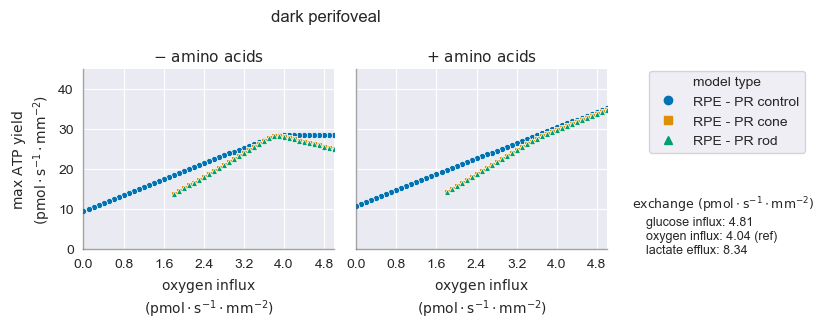

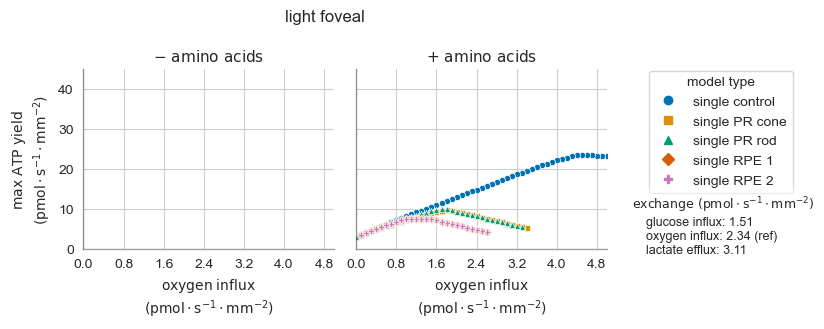

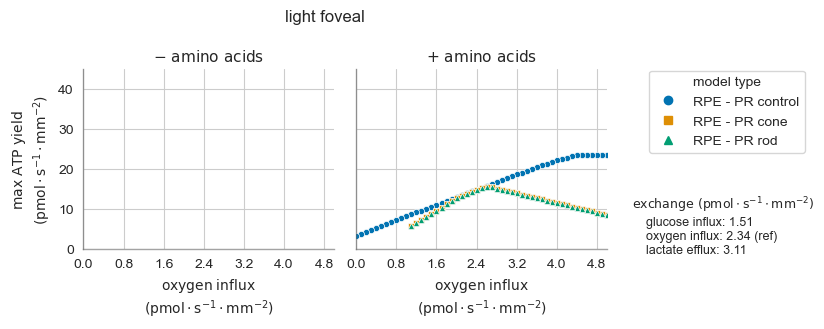

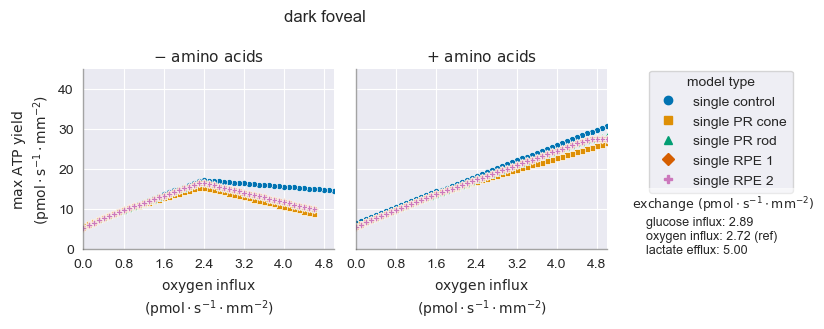

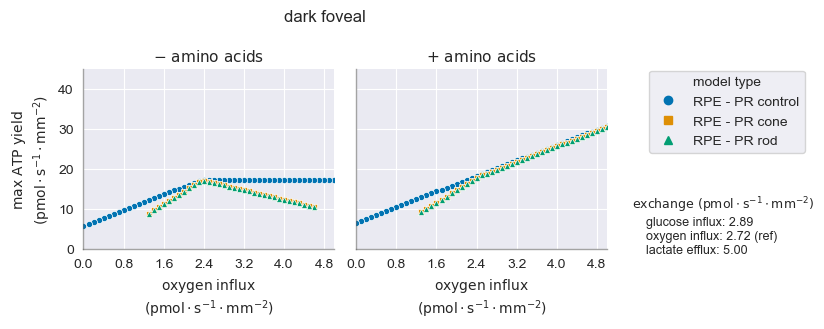

In [ ]:
# make oxygen figures
make_figs(oxygen_df,oxygen_ID, [(0,5), (0,5), (0,5), (0,5)])

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\axisgrid.py:216: UserWarning

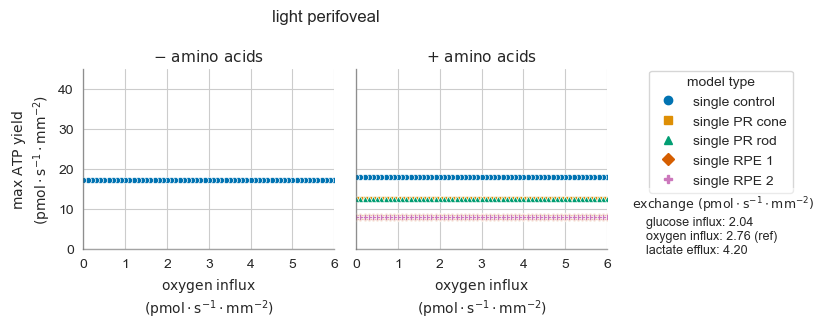

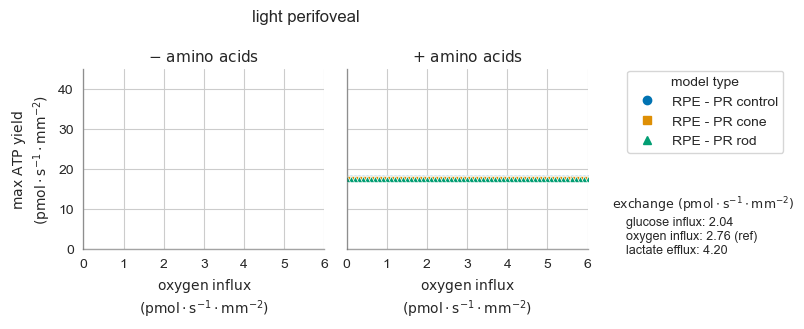

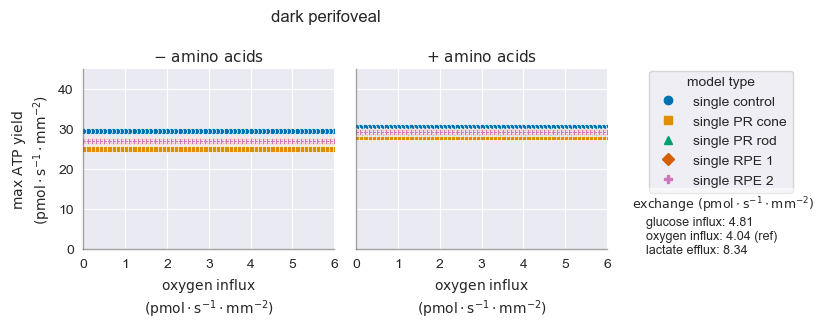

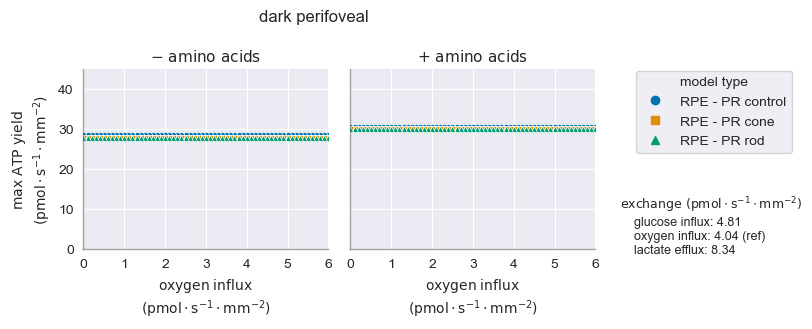

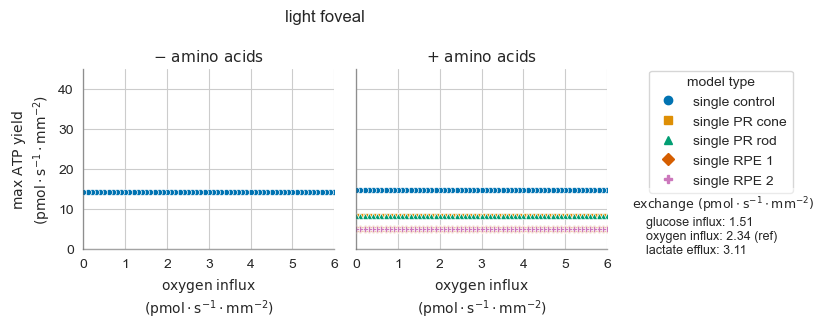

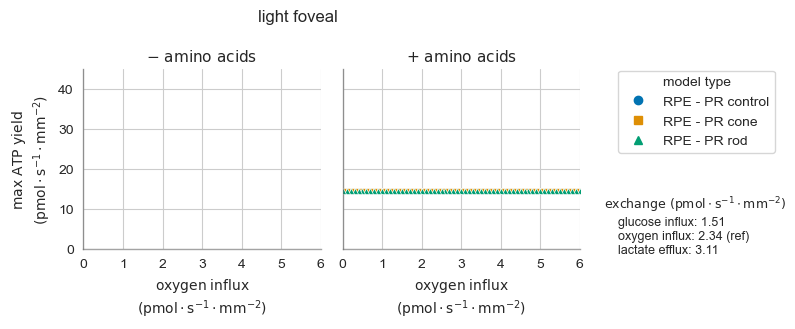

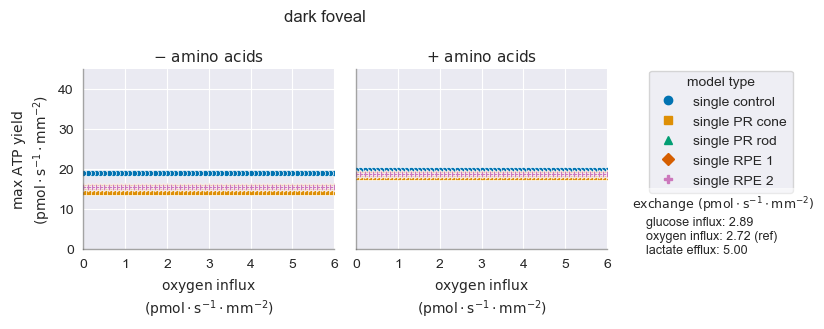

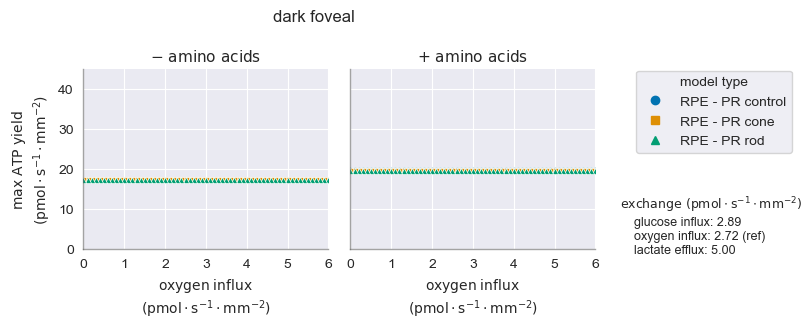

In [ ]:
# make oxygen figures (with efflux allowed)
make_figs(oxygen_df2,oxygen_ID, [(0,6), (0,6), (0,6), (0,6)])

Why is ATP yield going down as oxygen increases (after a certain point)?

investigate flux distributions

for single models 
- PR cone
- RPE 1
- control

Test: dark perifoveal with 3 oxygen levels 
- 0  (anaerobic)
- 4.04 (default oxygen)
- 6.00 (high oxygen)

In [ ]:
test_models = [model_list[0], model_list[2], model_list[3]]

In [ ]:
# PERIFOVEAL
# IMPOSE ex_bounds_dark_perifoveal and after that change the oxygen levels

# no oxygen
anaerobic = {'MAR09048_RPE':(0,0),\
             'MAR09048_PR':(0,0)}

# normal oxygen
RPE_ox = -4.04 * 3.48 / (3.48+0.56)
PR_ox = -4.04 * 0.56 / (3.48+0.56) 
normal_oxygen = {'MAR09048_RPE':(RPE_ox,RPE_ox),\
             'MAR09048_PR':(PR_ox,PR_ox)}

# high oxygen
RPE_ox = -6 * 3.48 / (3.48+0.56)
PR_ox = -6 * 0.56 / (3.48+0.56) 
high_oxygen = {'MAR09048_RPE':(RPE_ox,RPE_ox),\
             'MAR09048_PR':(PR_ox,PR_ox)}

ox_bounds = [anaerobic, normal_oxygen, high_oxygen]


for m in test_models:
    set_bounds(m, ex_bounds_dark_perifoveal)
    results_name = m.id + '_dark_perifoveal'
    fba_fva_analysis(m, results_name = results_name, boundary_dicts = ox_bounds)